# Summary - Capital One Data Science Challenge

## Q1. Load
- Please describe the structure of the data. Number of records and fields in each record?
    - Number of records: 786,363 across total 29 columns
    - Fields in each record: There are numeric, text, date and categorical fields. Date columns are not in date-time format, and required conversions.
        - Categorical fields: There are 10 categorical fields. They are: merchantCategoryCode, merchantCountryCode, merchantName, merchantState, merchantZip, merchantCity, customerTotalTransactions, customerAvgTransactionAmount, merchantTotalTransactions, merchantAvgTransactionAmount
        - Date fields: transactionDateTime, currentExpDate, accountOpenDate, dateofLastAddressChange are signifying date format but are text in value. I converted them to datetime format.
        - null values aren't actually NULL values, but rather empty strings.
- Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.
    - Basic summary statistics for each field are given in the section below. 
    - Numeric field values have logical upper and lower bounds. For example, availableMoney contains values which are even negative but that makes sense as current balance > credit Limit which makes available money negative.
    - In a way categorical fields exits such as for example merchatCategoryCode, merchantCountryCode etc. I identified these and use label encoding to convert them to numerical values.

## Q2. Plot
- Plot a histogram of the processed amounts of each transaction, the transactionAmount column.
    - Done in the Plot section below.

- Report any structure you find and any hypotheses you have about that structure.
    - Histogram of transactionAmount is skewed to the right. There are a lot of large values. I think this is because of the large number of fraudulent transactions.
    - Most of the transcations are less than 500$, which show case that probably most of transactions are about everyday transcactions of customers like grocery, bill pay, travel, entertainment etc.
    - As we are going to use these transactions for fraud detection, it's probably the case that fraud ones are mostly about large transactions.

## Q3. Data Wrangling - Duplicate Transactions
- Can you programmatically identify reversed and multi-swipe transactions?
    - Explained in Data Wrangling section below

- What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)
    - 5,502 transactions are reveresed and 7,342 are multi-swipe transactions. Total transactions are 12,844 and total dollar amount is $1,911,991. $824K in reversed and $1.08M in multi-swipe transactions.

- Did you find anything interesting about either kind of transaction?
    - I did not find any statistical relationship between isFraud and the reversed or multi-swipe transactions in terms of correlation. 
    - However, one interesting observation for the merchants pertaining to the reversed or multi-swipe transactions is that they are either taxi-companies like Uber or lyft, or generally product-selling or clothing companies like apply, gap, target.
    - This shows that customers with these merchants are more likely to have a reversed or multi-swipe transaction than customers with other merchants.

## Q4. Model

- Provide an estimate of performance using an appropriate sample, and show your work.
    - All experiments are properly detailed and explained in the Model section.

- Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)
    - Modeling algorithm/method used and why: 
        - Conducted 5 experiments: Logistic Regression, Simple NN, Bigger NN, TabNet Transformer Model, Improved Tabnet with Focal Loss
        - All the rationale and model choice are explained in each of the sub-sections.
    - Features/data found useful:
        - Following features were used:
        
        `['availableMoney','transactionAmount', 'creditLimit', 'credit_utilization', 'tra_to_limit',
        'cb_to_limit', 'account_age', 'address_change_age', 'customerTotalTransactions', 'customerAvgTransactionAmount',
        'merchantTotalTransactions', 'merchantAvgTransactionAmount', 'isCVVEqual', 'is_reversed', 'is_multi_swipe']`

        - Here, as mentioned above, I did feature engineeering to allow for better understanding such as credit_utilization, isCVVEqual, transaction to credit limit ration and many other explained in the Feature engineering part

    - Questions?:
        - How is a transaction reported as fraudulent? 
        - What features are most important for fraud marking?
        - Is poConditionCode important for fraud marking and what different values showcase fraud?
        - How were these transactions chosen, and how were they selected?

    - Things I would do if I had more time:
        - Explained at the very end of this notebook.
    


#### How to run this notebook? 

- Make sure you have installed all the required packages

    - `pip3 install pandas numpy matplotlib seaborn scikit-learn torch tqdm imbalanced-learn`  

- Make sure you have the transactions.txt file in the same directory

- Now run the cells in the notebook 



### 1. Load Data

In [ ]:
import pandas as pd
import json
import datetime

In [ ]:
def load_transactions(path:str) -> pd.DataFrame:
    # Firstly parsing the txt based on lines
    with open(path) as f:
        lines = [json.loads(x) for x in f.readlines()]
    return pd.DataFrame(lines)

In [ ]:
if os.path.exists('./transactions.csv'):
    df = pd.read_csv('./transactions.csv')
else:
df = load_transactions(path = './transactions.txt')


In [ ]:
pd.set_option('display.max_columns', None)
df.head(10)

,Unnamed: 0,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,0,737265056,737265056,5000.0,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,2.0,1.0,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
1,1,737265056,737265056,5000.0,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,9.0,1.0,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
2,2,737265056,737265056,5000.0,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,9.0,1.0,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
3,3,737265056,737265056,5000.0,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,9.0,1.0,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
4,4,830329091,830329091,5000.0,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,2.0,1.0,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
5,5,830329091,830329091,5000.0,5000.00,2016-04-19T16:24:27,30.76,In-N-Out #422833,US,US,2.0,1.0,fastfood,01/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
6,6,830329091,830329091,5000.0,5000.00,2016-05-21T14:50:35,57.28,Krispy Kreme #685312,US,US,2.0,1.0,fastfood,05/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
7,7,830329091,830329091,5000.0,5000.00,2016-06-03T00:31:21,9.37,Shake Shack #968081,US,US,5.0,1.0,fastfood,01/2021,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
8,8,830329091,830329091,5000.0,4990.63,2016-06-10T01:21:46,523.67,Burger King #486122,NaN,US,2.0,1.0,fastfood,08/2032,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,9.37,NaN,NaN,NaN,True,NaN,NaN,False,False
9,9,830329091,830329091,5000.0,5000.00,2016-07-11T10:47:16,164.37,Five Guys #510989,US,US,5.0,8.0,fastfood,04/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False


## Understanding Data

- 'accountNumber' : Unique identifier for account holder's transaction
- 'customerId' :  Unique ID for customer
- 'creditLimit' : ***Numerical*** - Credit limit for the account
- 'availableMoney' : ***Numerical*** - amount of money in the accont at time of the transaction
- 'transactionDateTime' :  Date-Time of transaction
- 'transactionAmount' : ***Numerical*** - Amount of transaction
- 'merchantName' : Name of merchant where transaction happened
- 'acqCountry' : Acquiring Bank's country
- 'merchantCountryCode' : Country code of the merchant
- 'posEntryMode' : Point of Sale entry mode
- 'posConditionCode' : Point of Sale condition code
- 'merchantCategoryCode' : Categorgy code of merchant
- 'currentExpDate' : Current expiration date of customer's card
- 'accountOpenDate' : Date at which Account was opened
- 'dateOfLastAddressChange' : Date of when the account owner's address last changed
- 'cardCVV' : CVV code of card
- 'enteredCVV' : CVV code entered by the user at time of transaction
- 'cardLast4Digits' : Last 4 digits of card
- 'transactionType' : type of transaction (purchase, withdrawal
- 'echoBuffer' : Seems a placeholder for extra/buffer data
- 'currentBalance' : ***Numerical*** Current credit balance
- 'merchantCity' : The city of merchant
- 'merchantState' : The state of merchant
- 'merchantZip' : Zip code for merchant
- 'cardPresent' : ***boolean*** signifies if card was present during transaction
- 'posOnPremises' : point of sale premises
- 'recurringAuthInd' : ***boolean*** indicates if transaction is a part of another recurring transaction
- 'expirationDateKeyInMatch' : ***boolean*** shows whether expiration date was entered correctly
- 'isFraud' : ***boolean*** shows transaction is fraudulent or not.


Below cells showcase basic stats for the data.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                786363 non-null  int64  
 1   accountNumber             786363 non-null  int64  
 2   customerId                786363 non-null  int64  
 3   creditLimit               786363 non-null  float64
 4   availableMoney            786363 non-null  float64
 5   transactionDateTime       786363 non-null  object 
 6   transactionAmount         786363 non-null  float64
 7   merchantName              786363 non-null  object 
 8   acqCountry                781801 non-null  object 
 9   merchantCountryCode       785639 non-null  object 
 10  posEntryMode              782309 non-null  float64
 11  posConditionCode          785954 non-null  float64
 12  merchantCategoryCode      786363 non-null  object 
 13  currentExpDate            786363 non-null  o

> Let's get an overall description of the data, with things like count, unique, min, max etc..

In [ ]:
df.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,786363.0,NaN,NaN,NaN,393181.0,227003.589202,0.0,196590.5,393181.0,589771.5,786362.0
accountNumber,786363.0,NaN,NaN,NaN,537232599.461703,255421092.307358,100088067.0,330133277.0,507456073.0,767620004.0,999389635.0
customerId,786363.0,NaN,NaN,NaN,537232599.461703,255421092.307358,100088067.0,330133277.0,507456073.0,767620004.0,999389635.0
creditLimit,786363.0,NaN,NaN,NaN,10759.464459,11636.17489,250.0,5000.0,7500.0,15000.0,50000.0
availableMoney,786363.0,NaN,NaN,NaN,6250.725369,8880.783989,-1005.63,1077.42,3184.86,7500.0,50000.0
transactionDateTime,786363,776637,2016-12-25T14:04:15,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transactionAmount,786363.0,NaN,NaN,NaN,136.985791,147.725569,0.0,33.65,87.9,191.48,2011.54
merchantName,786363,2490,Uber,25613,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acqCountry,781801,4,US,774709,NaN,NaN,NaN,NaN,NaN,NaN,NaN
merchantCountryCode,785639,4,US,778511,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> Let's check null values

In [ ]:
null_values = df.isnull().sum()
print(f"Total Null values per column : \n{null_values}")

Total Null values per column : 
Unnamed: 0                       0
accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd       

## 2. Performing EDA and Plot

It's important to have an EDA (Exploratory Data Analysis) to understand the data and patterns much better. We will use plots here

Let's check first the distributions.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# helper function
def plot_histogram(title: str, x_label: str, y_label: str, data, bins = 50, kde = True):
    size = (10,6)
    plt.figure(figsize = size)
    # Using seaborn for histogram plotting
    sns.histplot(data, bins=bins, kde = kde, color='red')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

### Transaction Amounts

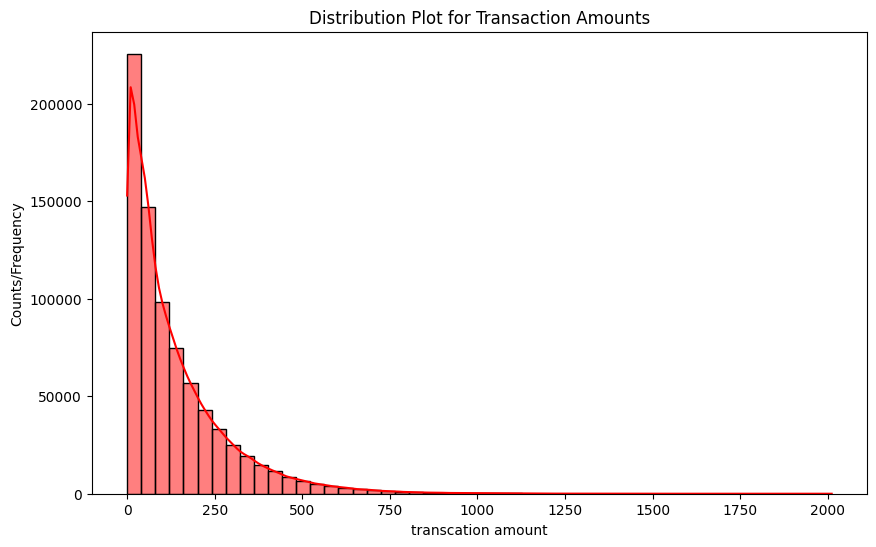

In [ ]:
plot_histogram("Distribution Plot for Transaction Amounts", x_label="transcation amount", y_label="Counts/Frequency", data = df['transactionAmount'])

Based on the above plot, it can be seen that most of the transactions that happened corresponding to this dataset are of lower monetary amount, there's is a very steep drop-down of the number of transactions that happen as the transaction amount increases. This is in-a-way typical transaction data as small-amount transactions happen more often than large ones

### Credit limit

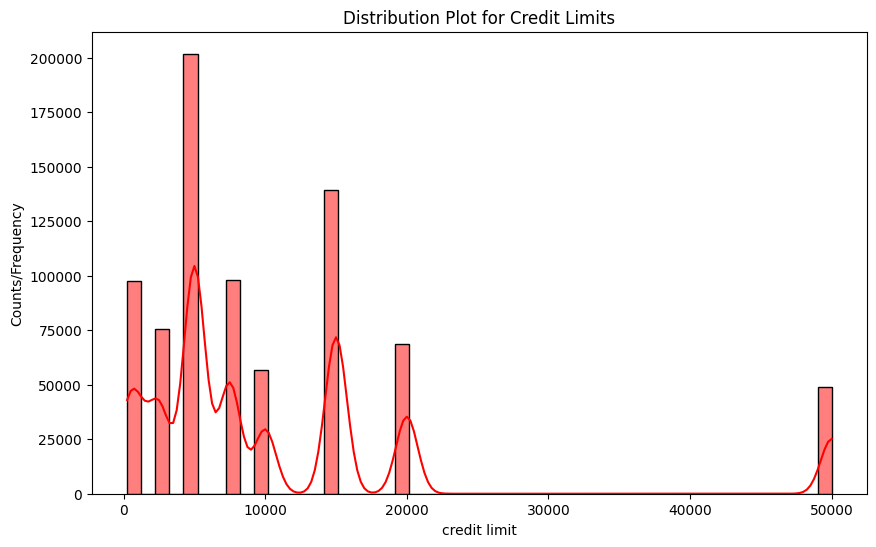

In [ ]:
plot_histogram("Distribution Plot for Credit Limits", x_label="credit limit", y_label="Counts/Frequency", data = df['creditLimit'])

Based on this plot, it seems there are various peaks for credit limit based on frequencies, some credit limit typcially between 0-10000 are more common. This distribution seems to suggest there are credit limit tiers providied by the banking institution.

### Available Money

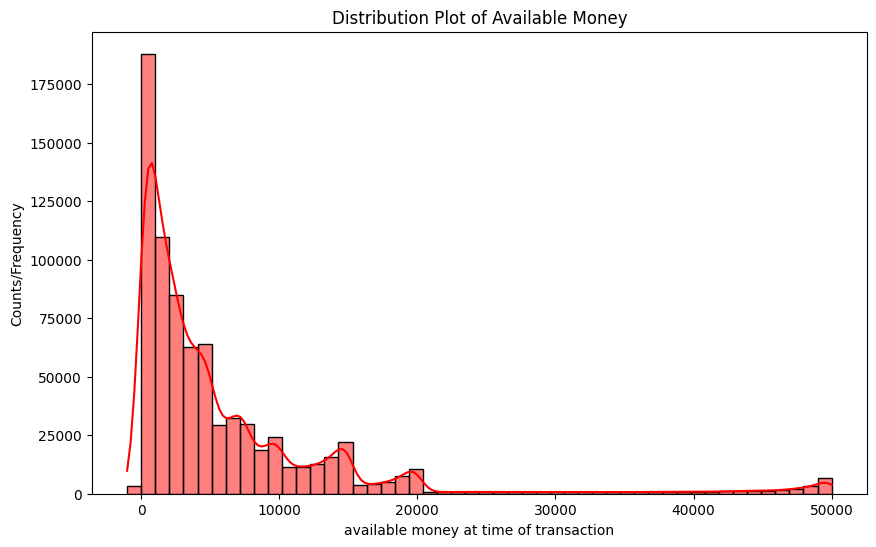

In [ ]:
plot_histogram("Distribution Plot of Available Money", x_label="available money at time of transaction", y_label="Counts/Frequency", data = df['availableMoney'])

Based on this, it can be inferred that many of the transactions happen with lower values of amount of money in the bank for the account holder, which aligns with the transaction amount distribution plot

Observations:

Key numerical features that we observed via plots showcase following things about this dataset:
- Transaction amounts are majorly of lower value, very few are of high-value.
- Available money corresponding to transaction amounts is also low mostly
- Credit limit suggest a tier-system to reflect offerings by bank based on financial criterias of the account holder

These observations will be kept in consideration while building our fraud detection model.

### Let's now focus on numerical columns and isFraud based class analysis

As from our previous made observations, we have seen that there are some sort of co-relation between the numerical columns like available moeney and transaction amounts. Let's dive deep into this:

In [ ]:
numerical_df = df.select_dtypes(include='float64')

In [ ]:
matrix = numerical_df.corr() # Getting correlation matrix

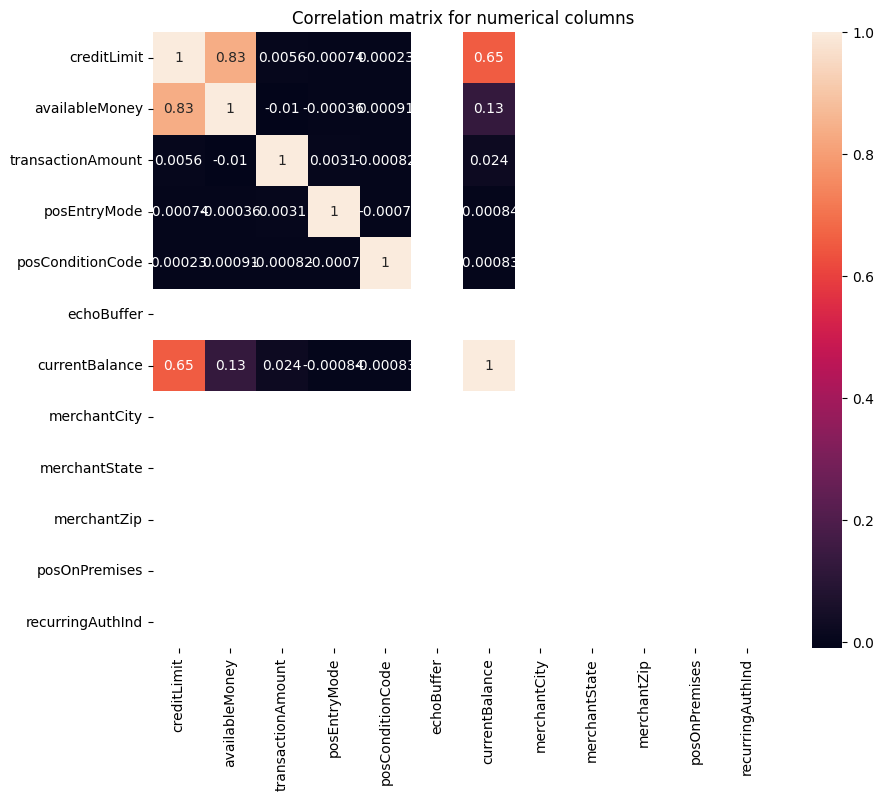

In [ ]:
# Plotting the matrix as a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, cbar= True)
plt.title("Correlation matrix for numerical columns")
plt.show()

Based on the heatmap, following observations can be made:

- Credit Limit and Available Money in the bank are having high correlation (0.83) suggesting if more money in account, higher is the credit limit which makes sense
    - Credit Limit and current balance also suggests same
- Transaction Amount has little to no correlation for the other variables here, so transaction amount is not actually dependent on other factors related to limit, money available, balance
- Available money and current balance also show less correlation (0.13).

Let's see now the main variable to build model upon to predict - `isFraud`

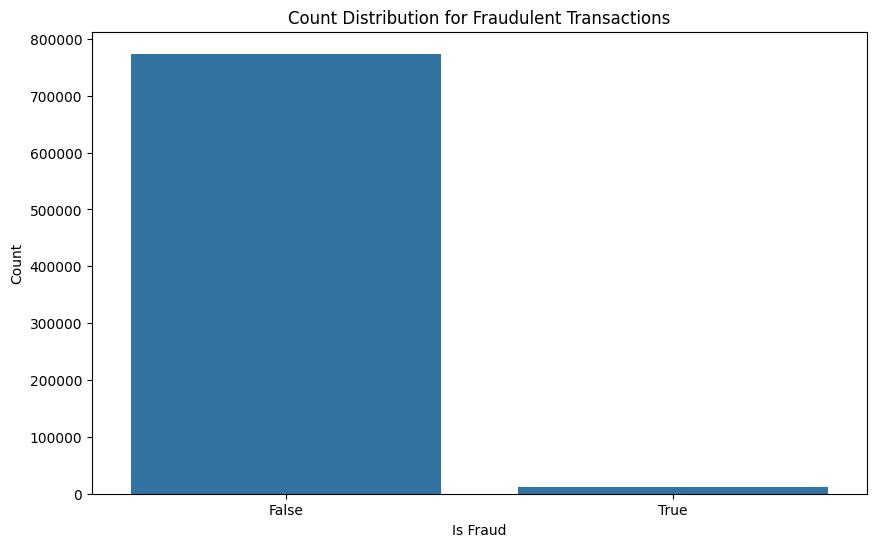

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='isFraud', data =df)
plt.title('Count Distribution for Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

In [ ]:
# Checking how many are isFraud out of total in the df.
total_frauds = df.isFraud.sum()
total_transactions = df.shape[0]

print(f"Fradulent Transactions out of total : {total_frauds/total_transactions}")

Fradulent Transactions out of total : 0.01579041740264992


From the plot, we can see there is a very high **imbalance** for `isFraud` in the dataset. 1.579% of total transactions.

This imbalance will be influencing our predictions, so we have to keep this imbalance in mind as the model trained on this dataset will be more bias towards prediction of the majority (Non-Fraud) class, which can lead to lot of FN (False-negative) predictions.

Keeping in mind the imbalance factor, we have to take following considerations for our training and evaluation:

- Metrics:
    -  Accuracy won't be a good metric to use due to imbalance, high accuracy doesn't actually mean we are predicting rightly as majority of transactions are non-fraud.
    - We will instead foucs on metrics like precision, recall, F1-score, area under ROC for evaluation

- Techniques to employ:
    - As imbalance is high, we can apply resampling strategy, such as ;
        - over-sampling : Upping the minority (isFraud = True) class using methods such as SMOTE (Synthetic minority over-sampling technique)
        - under-sampling : Decreasing samples for majority (isFraud = False) class
        - Mix of both

- Models to choose:
    - We will go through a bunch of ML/DL models which are robust to imbalance nature of the dataset.
    - Including weight assignment to class to allow say for example loss function to penalize more for wrong predictions made by model concerning fraudulent transactions.


### 3. Data Wrangling - Duplicate Transactions

In [ ]:
df.head(10)

,Unnamed: 0,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,0,737265056,737265056,5000.0,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,2.0,1.0,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
1,1,737265056,737265056,5000.0,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,9.0,1.0,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
2,2,737265056,737265056,5000.0,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,9.0,1.0,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
3,3,737265056,737265056,5000.0,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,9.0,1.0,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
4,4,830329091,830329091,5000.0,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,2.0,1.0,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
5,5,830329091,830329091,5000.0,5000.00,2016-04-19T16:24:27,30.76,In-N-Out #422833,US,US,2.0,1.0,fastfood,01/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
6,6,830329091,830329091,5000.0,5000.00,2016-05-21T14:50:35,57.28,Krispy Kreme #685312,US,US,2.0,1.0,fastfood,05/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
7,7,830329091,830329091,5000.0,5000.00,2016-06-03T00:31:21,9.37,Shake Shack #968081,US,US,5.0,1.0,fastfood,01/2021,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
8,8,830329091,830329091,5000.0,4990.63,2016-06-10T01:21:46,523.67,Burger King #486122,NaN,US,2.0,1.0,fastfood,08/2032,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,9.37,NaN,NaN,NaN,True,NaN,NaN,False,False
9,9,830329091,830329091,5000.0,5000.00,2016-07-11T10:47:16,164.37,Five Guys #510989,US,US,5.0,8.0,fastfood,04/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False


Duplciated Transactions are present, some can be seen above.

To be specific, there are :

- Reversed Transaction: Purchase done but then reversal
- Multi-swipe: Accidentaly vendor charged multiple times within short time span

Let's look at these

In [ ]:
df['transactionType'].unique()

array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', nan], dtype=object)

There are three main types of transactions in a card:
1. PURCHASE
2. ADDRESS_VERIFICATION
3. REVERSAL

In [ ]:
# Basically using transaction type to find the reversal transactions
df[df['transactionType'] == "REVERSAL"].head(5)

,Unnamed: 0,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
39,39,574788567,574788567,2500.0,2200.98,2016-05-24T01:38:03,215.13,Convenient Tire,US,US,9.0,1.0,auto,10/2021,2015-10-13,2015-10-13,206,206,8522,REVERSAL,NaN,299.02,NaN,NaN,NaN,True,NaN,NaN,False,False
73,73,574788567,574788567,2500.0,2432.72,2016-10-07T10:23:57,3.87,Eazy Repair,US,US,5.0,1.0,auto,10/2022,2015-10-13,2015-10-13,579,579,4219,REVERSAL,NaN,67.28,NaN,NaN,NaN,True,NaN,NaN,False,False
101,101,924729945,924729945,50000.0,49831.43,2016-10-19T14:01:45,168.57,discount.com,US,US,5.0,1.0,online_retail,11/2024,2014-07-25,2014-07-25,205,265,9459,REVERSAL,NaN,168.57,NaN,NaN,NaN,False,NaN,NaN,False,False
133,133,984504651,984504651,50000.0,46367.41,2016-01-16T09:53:15,450.74,Planet Fitness #849960,US,US,5.0,1.0,health,08/2028,2015-07-27,2015-07-27,640,640,8332,REVERSAL,NaN,3632.59,NaN,NaN,NaN,False,NaN,NaN,False,False
156,156,984504651,984504651,50000.0,41909.30,2016-01-25T20:39:15,81.73,AMC #724446,US,US,9.0,1.0,entertainment,12/2031,2015-07-27,2015-07-27,640,640,8332,REVERSAL,NaN,8090.70,NaN,NaN,NaN,True,NaN,NaN,False,False


So we are able to get reversal transactions, but multi-swipe transactions need to be identified more specifically.

Let's first create a helper function to sort transactions by account number, customerID, card, and transaction date, this will help us have a sorted list of transactions.

We will focus on following columns:

- account number
- customerID
- cardLast4Digits
- transactionDateTime
- transactionAmount
- transactionType
- merchantName

I am using these columns as they signify the differences for reversal and multi-swipe transactions. Specifically:
1. If we will look at transactions, we can see that if the transactionAmount of REVERSAL is same as previous transaction, from same merchantName,  then it is a reversal transaction.
2. If the upcoming transaction/transactions have same transactionAmount, from same merchantName, then it is a multi-swipe transaction. since df is already sorted by transactionDateTime, we can just check the next transactionAmount and merchantName to see if it is a multi-swipe transaction.

In [ ]:
# Example post sorting
df2 = df.sort_values(by=['accountNumber', 'customerId', 'cardLast4Digits', 'transactionDateTime'], ascending = True).reset_index(drop=True)
df2.head(10)

,Unnamed: 0,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,541902,100088067,100088067,50000.0,49748.44,2016-01-17T15:41:46,378.67,Mobile eCards,US,US,5.0,1.0,online_gifts,11/2031,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,251.56,NaN,NaN,NaN,False,NaN,NaN,False,False
1,541905,100088067,100088067,50000.0,49792.33,2016-02-08T06:09:12,259.44,Blue Mountain eCards,US,US,5.0,1.0,online_gifts,01/2028,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,207.67,NaN,NaN,NaN,False,NaN,NaN,False,False
2,541906,100088067,100088067,50000.0,49532.89,2016-02-09T18:36:53,32.50,EZ Putt Putt #804489,US,US,9.0,1.0,entertainment,07/2026,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,467.11,NaN,NaN,NaN,True,NaN,NaN,False,False
3,541908,100088067,100088067,50000.0,49477.33,2016-02-13T20:17:41,56.05,Fresh Flowers,US,US,5.0,1.0,online_gifts,01/2033,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,522.67,NaN,NaN,NaN,False,NaN,NaN,False,False
4,541913,100088067,100088067,50000.0,49923.92,2016-03-12T12:55:28,97.79,Dinosaur Sandwitch Bar #960325,US,US,5.0,1.0,food,01/2032,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,76.08,NaN,NaN,NaN,True,NaN,NaN,False,False
5,541915,100088067,100088067,50000.0,49769.86,2016-03-25T21:32:36,161.45,Fresh eCards,US,US,5.0,1.0,online_gifts,07/2026,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,230.14,NaN,NaN,NaN,False,NaN,NaN,False,False
6,541916,100088067,100088067,50000.0,50000.00,2016-04-01T04:47:33,46.19,Fresh Online Services,US,US,5.0,1.0,online_gifts,06/2023,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
7,541922,100088067,100088067,50000.0,49758.31,2016-05-16T20:33:00,71.41,Next Day eCards,US,US,5.0,1.0,online_gifts,08/2031,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,241.69,NaN,NaN,NaN,False,NaN,NaN,False,False
8,541923,100088067,100088067,50000.0,49686.90,2016-05-24T00:44:16,10.00,Next Day eCards,US,US,5.0,1.0,online_gifts,07/2029,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,313.10,NaN,NaN,NaN,False,NaN,NaN,False,False
9,541927,100088067,100088067,50000.0,49691.89,2016-06-20T20:11:51,131.38,EZ Putt Putt #240241,US,US,2.0,1.0,entertainment,09/2032,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,308.11,NaN,NaN,NaN,True,NaN,NaN,False,False


Let's create this helper function:
- It is taking in the original dataframe, sorting it as mentioned above
- Then we are performing shifting on the dataframe, creating new columns "*_shifted" they have the value of previous row for each column, this helps in comparing each row to previous transaction row
- This will be helpful to identify transactions as reversed or multi-swipe easily
- We are using the "shift" function from the pandas library, periods here means the number of rows to shift, the columns chosen are what we discussed above

In [ ]:
def process_transactions(transactions_df):
    # Convert the transaction date to datetime format to help in sorting
    transactions_df['transactionDateTime'] = pd.to_datetime(transactions_df['transactionDateTime'])
    transactions_df['accountOpenDate'] = pd.to_datetime(transactions_df['accountOpenDate'])
    transactions_df['dateOfLastAddressChange'] = pd.to_datetime(transactions_df['dateOfLastAddressChange'])

    # Sort transactions by account, customer, card, and transaction time, ascending order
    transactions_df = transactions_df.sort_values(by=['accountNumber', 'customerId', 'cardLast4Digits', 'transactionDateTime'], ascending=True).reset_index(drop=True)

    # Create shifted columns to compare each transaction with the previous one will be useful later
    transactions_df['accountNumber_shifted'] = transactions_df.accountNumber.shift(periods=1, axis = 0)
    transactions_df['customerId_shifted'] = transactions_df.customerId.shift(1, axis = 0)
    transactions_df['cardLast4Digits_shifted'] = transactions_df.cardLast4Digits.shift(1, axis = 0)
    transactions_df['transactionDateTime_shifted'] = transactions_df.transactionDateTime.shift(1, axis = 0)
    transactions_df['transactionAmount_shifted'] = transactions_df.transactionAmount.shift(1, axis = 0)
    transactions_df['transactionType_shifted'] = transactions_df.transactionType.shift(1, axis = 0)
    transactions_df['merchantName_shifted'] = transactions_df.merchantName.shift(1, axis = 0)

    return transactions_df

In [ ]:
def get_reversal_transactions(df):
    # helper function to identify reversal transactions logic
    def is_reversed(row):
        # Logic:
        # if account number, customerID, card last 4 digits, transaction amount, merchant name are same as previous transaction,
        # and the transaction date time is whithing the day limit, and current transaction is REVERSAL, previous transaction type is PURCHASE
        # then we have a reversal transaction
        return (
            (row['accountNumber'] == row['accountNumber_shifted']) &
            (row['customerId'] == row['customerId_shifted']) &
            (row['cardLast4Digits'] == row['cardLast4Digits_shifted']) &
            (row['transactionDateTime'] <= (row['transactionDateTime_shifted'] + datetime.timedelta(hours=24))) &
            (row['transactionType'] == 'REVERSAL') &
            (row['transactionType_shifted'] == 'PURCHASE') &
            (row['transactionAmount'] == row['transactionAmount_shifted']) &
            (row['merchantName'] == row['merchantName_shifted'])
        )

    df['is_reversed'] = df.apply(is_reversed, axis=1) # New Column
    reversed_transactions = df[df['is_reversed']]

    total_reversals = len(reversed_transactions)
    total_reversal_amount = reversed_transactions['transactionAmount'].sum()

    return df, total_reversals, total_reversal_amount

def get_multi_swipe_transactions(df):
    # helper function to identify multi swipe transactions logic
    def is_multi_swipe(row):
        # Logic:
        # if account number, customerID, card last 4 digits, transaction amount, merchant name are same as previous transaction,
        # and the transaction date time is whithing the day limit, and current transaction is PURCHASE, previous transaction type is PURCHASE
        # then we have a multi swipe transaction
        return (
            (row['accountNumber'] == row['accountNumber_shifted']) &
            (row['customerId'] == row['customerId_shifted']) &
            (row['cardLast4Digits'] == row['cardLast4Digits_shifted']) &
            (row['transactionDateTime'] <= (row['transactionDateTime_shifted'] + datetime.timedelta(hours=24))) &
            (row['transactionType'] == 'PURCHASE') &
            (row['transactionType_shifted'] == 'PURCHASE') &
            (row['transactionAmount'] == row['transactionAmount_shifted']) &
            (row['merchantName'] == row['merchantName_shifted'])
        )

    df['is_multi_swipe'] = df.apply(is_multi_swipe, axis=1) # New column
    multi_swipe_transactions = df[df['is_multi_swipe']]

    total_multi_swipes = len(multi_swipe_transactions)
    total_multi_swipe_amount = multi_swipe_transactions['transactionAmount'].sum()

    return df, total_multi_swipes, total_multi_swipe_amount


In [ ]:
# process transactions
transactions_df = process_transactions(df)
transactions_df, total_reversals, total_reversal_amount = get_reversal_transactions(transactions_df)
transactions_df, total_multi_swipes, total_multi_swipe_transaction_amount = get_multi_swipe_transactions(transactions_df)

print("Total number of reversed transactions:", total_reversals)
print("Total dollar amount of reversed transactions:", total_reversal_amount)
print("Total number of multi-swipe transactions:", total_multi_swipes)
print("Total dollar amount of multi-swipe transactions:", total_multi_swipe_transaction_amount)
print("Transactions dataframe with duplicate transaction flags in detail:")
print('\n\n')
# print(transactions_df.to_string())

Total number of reversed transactions: 5502
Total dollar amount of reversed transactions: 824826.52
Total number of multi-swipe transactions: 7342
Total dollar amount of multi-swipe transactions: 1087165.85
Transactions dataframe with duplicate transaction flags in detail:





In [ ]:
# percentage of total reversals
print(f" Total percentage of reversals is {total_reversals/transactions_df.shape[0]*100:.2f}%")

# percentage of total multi-swipes
print(f" Total percentage of multi-swipes is {total_multi_swipes/transactions_df.shape[0]*100:.2f}%")

 Total percentage of reversals is 0.70%
 Total percentage of multi-swipes is 0.93%


#### Observation
- total count of reversed transactions are : **5502**
    - Total dollar amount excluding original transactions for reversed transactions are : **$824826.52**
- total count of multi-swipe transactions are : **7342**
    - Total dollar amount excluding original transactions for multi-swipe transactions are : **$1087165.85**


In [ ]:
transactions_df[(transactions_df['is_reversed'] == True) & (transactions_df['isFraud'] == True)]

,Unnamed: 0,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,accountNumber_shifted,customerId_shifted,cardLast4Digits_shifted,transactionDateTime_shifted,transactionAmount_shifted,transactionType_shifted,merchantName_shifted,is_reversed,is_multi_swipe
2061,690249,102755773,102755773,2500.0,2360.76,2016-09-14 17:46:10,49.94,ebay.com,US,US,9.0,1.0,online_retail,04/2025,2010-06-28,2016-07-30,875,875,2415,REVERSAL,NaN,139.24,NaN,NaN,NaN,False,NaN,NaN,False,True,102755773.0,102755773.0,2415.0,2016-09-14 17:44:31,49.94,PURCHASE,ebay.com,True,False
2118,690306,102755773,102755773,2500.0,217.48,2016-10-26 00:38:53,58.60,apple.com,US,US,2.0,1.0,online_retail,09/2028,2010-06-28,2016-07-30,875,875,2415,REVERSAL,NaN,2282.52,NaN,NaN,NaN,False,NaN,NaN,False,True,102755773.0,102755773.0,2415.0,2016-10-26 00:37:54,58.60,PURCHASE,apple.com,True,False
5863,126397,108011952,108011952,5000.0,1871.05,2016-07-23 00:13:58,49.55,cheapfast.com,US,US,9.0,1.0,online_retail,03/2023,2015-03-29,2015-03-29,336,336,5045,REVERSAL,NaN,3128.95,NaN,NaN,NaN,False,NaN,NaN,False,True,108011952.0,108011952.0,5045.0,2016-07-23 00:11:32,49.55,PURCHASE,cheapfast.com,True,False
6412,37228,110443122,110443122,10000.0,8899.16,2016-02-17 17:53:07,172.06,Delta Airlines,US,US,9.0,1.0,airline,11/2022,2015-02-22,2015-02-22,643,643,8953,REVERSAL,NaN,1100.84,NaN,NaN,NaN,False,NaN,NaN,False,True,110443122.0,110443122.0,8953.0,2016-02-17 17:51:14,172.06,PURCHASE,Delta Airlines,True,False
20862,665601,131007981,131007981,5000.0,3112.65,2016-10-24 18:11:39,190.63,EZ Putt Putt #755869,US,US,9.0,8.0,entertainment,11/2026,2015-09-08,2015-09-08,788,788,3292,REVERSAL,NaN,1887.35,NaN,NaN,NaN,True,NaN,NaN,False,True,131007981.0,131007981.0,3292.0,2016-10-24 18:11:37,190.63,PURCHASE,EZ Putt Putt #755869,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685559,683691,882010257,882010257,5000.0,1356.85,2016-04-03 08:32:04,251.81,staples.com,US,US,9.0,8.0,online_retail,07/2025,2012-07-12,2016-03-22,717,717,0,REVERSAL,NaN,3643.15,NaN,NaN,NaN,False,NaN,NaN,False,True,882010257.0,882010257.0,0.0,2016-04-03 08:30:04,251.81,PURCHASE,staples.com,True,False
737632,223957,937049207,937049207,15000.0,11927.34,2016-10-28 03:58:17,185.84,53rd Spa,US,US,9.0,1.0,personal care,07/2031,2009-12-10,2016-08-28,926,926,4641,REVERSAL,NaN,3072.66,NaN,NaN,NaN,True,NaN,NaN,False,True,937049207.0,937049207.0,4641.0,2016-10-28 03:55:53,185.84,PURCHASE,53rd Spa,True,False
743882,369888,941631553,941631553,2500.0,237.38,2016-05-13 20:53:29,297.09,Fast Auto Services,US,US,9.0,1.0,auto,05/2031,2014-08-02,2014-08-02,370,370,5639,REVERSAL,NaN,2262.62,NaN,NaN,NaN,True,NaN,NaN,False,True,941631553.0,941631553.0,5639.0,2016-05-13 20:51:24,297.09,PURCHASE,Fast Auto Services,True,False
765136,84242,965772421,965772421,20000.0,18857.75,2016-02-04 14:30:22,277.36,Merchants Tire,US,US,9.0,8.0,auto,09/2032,2012-07-25,2012-07-25,604,604,886,REVERSAL,NaN,1142.25,NaN,NaN,NaN,True,NaN,NaN,False,True,965772421.0,965772421.0,886.0,2016-02-04 14:29:12,277.36,PURCHASE,Merchants Tire,True,False


In [ ]:
transactions_df[(transactions_df['is_multi_swipe'] == True) & (transactions_df['isFraud'] == True)]

,Unnamed: 0,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,accountNumber_shifted,customerId_shifted,cardLast4Digits_shifted,transactionDateTime_shifted,transactionAmount_shifted,transactionType_shifted,merchantName_shifted,is_reversed,is_multi_swipe
14117,623783,124858654,124858654,500.0,500.00,2016-07-13 07:03:25,232.71,walmart.com,US,US,9.0,1.0,online_retail,12/2026,2013-11-25,2016-06-04,452,456,2861,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,True,124858654.0,124858654.0,2861.0,2016-07-13 07:00:34,232.71,PURCHASE,walmart.com,False,True
23745,200041,132629755,132629755,5000.0,606.84,2016-06-26 02:04:25,209.12,cheapfast.com,US,US,5.0,1.0,online_retail,12/2030,2015-12-17,2016-03-04,337,337,8208,PURCHASE,NaN,4393.16,NaN,NaN,NaN,False,NaN,NaN,False,True,132629755.0,132629755.0,8208.0,2016-06-26 02:02:46,209.12,PURCHASE,cheapfast.com,False,True
29101,639070,136585823,136585823,7500.0,4495.41,2016-08-07 01:46:47,61.01,AMC #706324,US,US,2.0,8.0,entertainment,05/2022,2015-02-20,2015-02-20,132,132,1614,PURCHASE,NaN,3004.59,NaN,NaN,NaN,True,NaN,NaN,False,True,136585823.0,136585823.0,1614.0,2016-08-07 01:45:48,61.01,PURCHASE,AMC #706324,False,True
30153,93270,137196389,137196389,10000.0,4923.99,2016-07-30 21:16:44,131.68,Domino's Pizza #702155,US,US,2.0,1.0,fastfood,07/2025,2011-04-26,2016-07-23,305,305,4094,PURCHASE,NaN,5076.01,NaN,NaN,NaN,True,NaN,NaN,False,True,137196389.0,137196389.0,4094.0,2016-07-30 21:15:00,131.68,PURCHASE,Domino's Pizza #702155,False,True
46563,685148,155257360,155257360,5000.0,4705.75,2016-09-08 11:39:37,163.42,Uber,US,US,NaN,1.0,rideshare,10/2023,2014-04-30,2014-04-30,963,963,2613,PURCHASE,NaN,294.25,NaN,NaN,NaN,False,NaN,NaN,False,True,155257360.0,155257360.0,2613.0,2016-09-08 11:36:48,163.42,PURCHASE,Uber,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732231,633596,926610883,926610883,1000.0,632.29,2016-09-12 10:24:16,102.48,target.com,US,US,2.0,1.0,online_retail,04/2027,2013-09-11,2013-09-11,969,969,9779,PURCHASE,NaN,367.71,NaN,NaN,NaN,False,NaN,NaN,False,True,926610883.0,926610883.0,9779.0,2016-09-12 10:21:33,102.48,PURCHASE,target.com,False,True
740782,94531,938195288,938195288,20000.0,10571.58,2016-10-10 22:01:14,354.59,AMC #552863,US,US,9.0,8.0,entertainment,07/2021,2014-02-24,2016-09-29,978,978,4548,PURCHASE,NaN,9428.42,NaN,NaN,NaN,True,NaN,NaN,False,True,938195288.0,938195288.0,4548.0,2016-10-10 21:59:26,354.59,PURCHASE,AMC #552863,False,True
746003,634001,946998095,946998095,10000.0,9362.61,2016-12-16 01:35:40,362.97,walmart.com,US,US,9.0,1.0,online_retail,04/2030,2015-04-29,2016-01-15,266,266,8667,PURCHASE,NaN,637.39,NaN,NaN,NaN,False,NaN,NaN,False,True,946998095.0,946998095.0,8667.0,2016-12-16 01:33:21,362.97,PURCHASE,walmart.com,False,True
757560,609057,955678177,955678177,1000.0,522.33,2016-09-26 06:19:50,67.92,Hardee's #229101,US,US,5.0,1.0,fastfood,09/2030,2013-03-03,2016-08-16,658,658,1490,PURCHASE,NaN,477.67,NaN,NaN,NaN,True,NaN,NaN,False,True,955678177.0,955678177.0,1490.0,2016-09-26 06:16:58,67.92,PURCHASE,Hardee's #229101,False,True


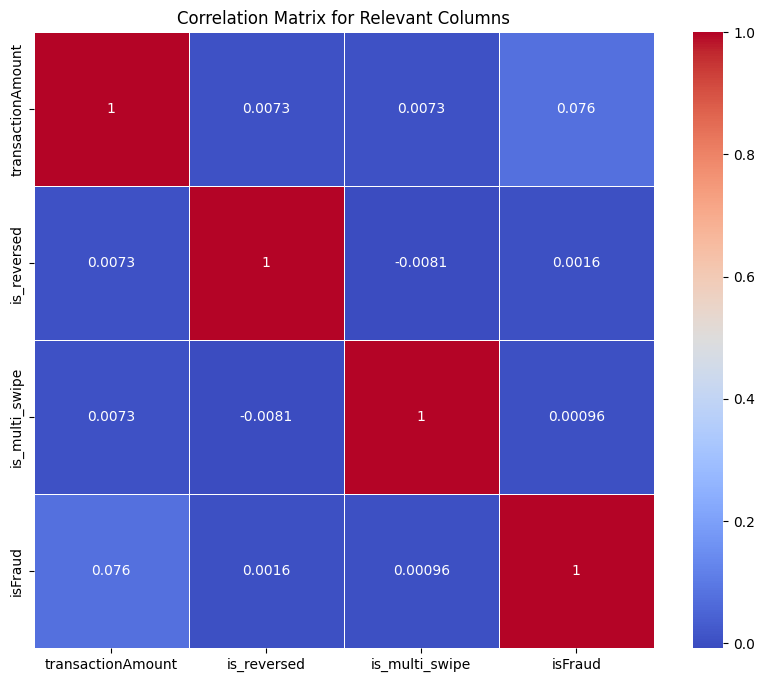

In [ ]:
def visualize_correlation_matrix(transactions_df):
    # Selecting relevant columns for correlation analysis
    relevant_columns = ['transactionAmount', 'is_reversed', 'is_multi_swipe', 'isFraud']
    correlation_df = transactions_df[relevant_columns]

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix for Relevant Columns')
    plt.show()
visualize_correlation_matrix(transactions_df)

Very very few of the multiswipe or reverse swipe transactions are fraudulent.
Let's take a look at the merchants pertaining to the reversal or multiswipe transactions.

In [ ]:
# Analyze merchants involved in reversed or multi-swipe transactions
merchant_analysis = transactions_df[(transactions_df['is_reversed']) | (transactions_df['is_multi_swipe'])]
merchant_counts = merchant_analysis['merchantName'].value_counts().reset_index()
merchant_counts.columns = ['merchantName', 'transactionCount']

print("Merchants involved in reversed or multi-swipe transactions:")
print(merchant_counts.to_string(index=False))

Merchants involved in reversed or multi-swipe transactions:
                  merchantName  transactionCount
                          Uber               475
                          Lyft               428
                     apple.com               330
                       gap.com               314
                   alibaba.com               310
                   oldnavy.com               307
                     sears.com               303
                   staples.com               296
                    amazon.com               296
                      ebay.com               296
                    target.com               293
                 cheapfast.com               286
                  discount.com               283
                   walmart.com               272
                 Mobile eCards               153
               Next Day eCards               149
 Blue Mountain Online Services               141
         Fresh Online Services               138
         

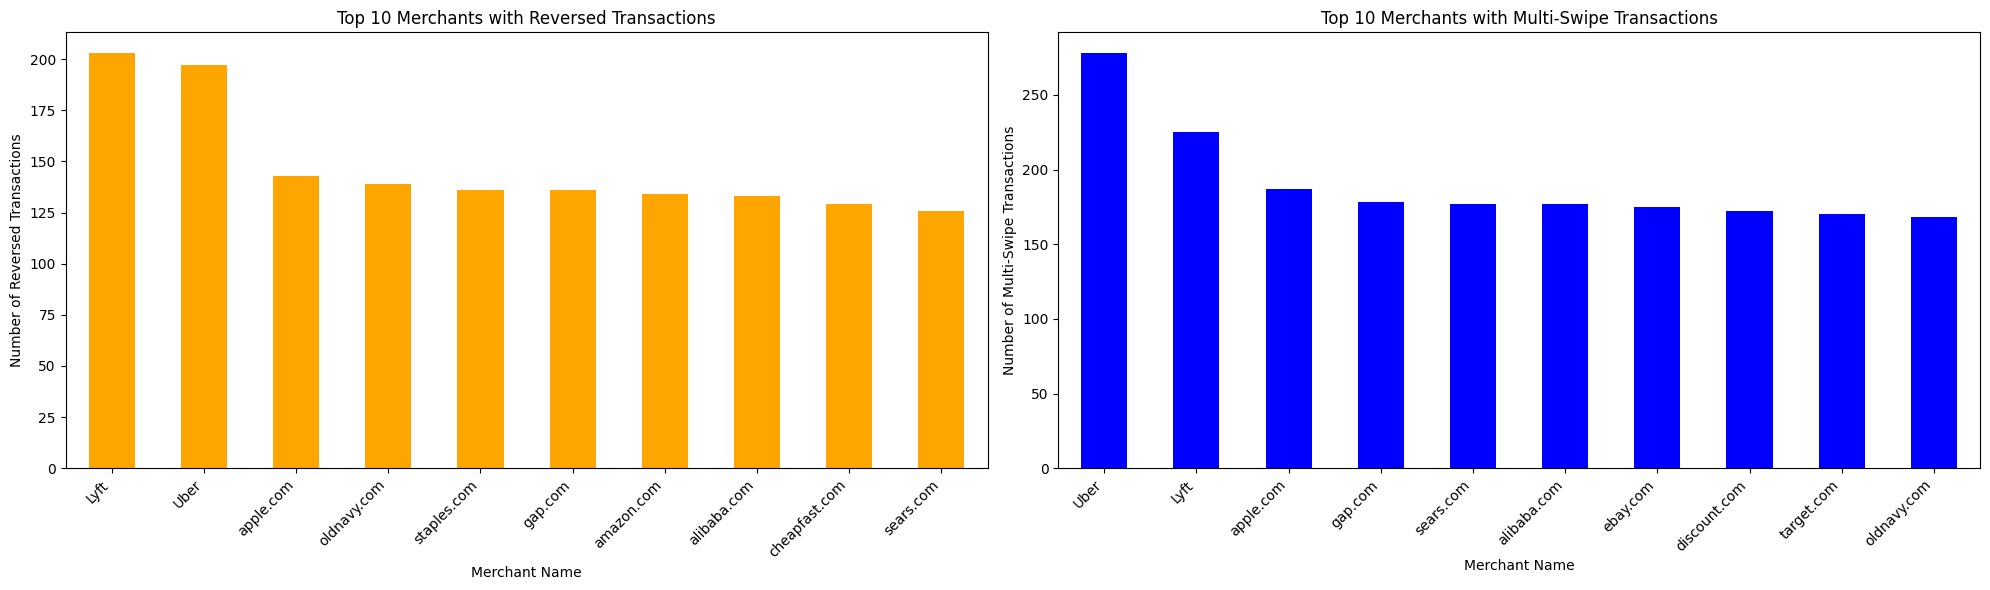

In [ ]:
def visualize_merchants_trends(transactions_df):
    #Plot reversed transactions with merchants trends
    merchant_reversal_counts = transactions_df[transactions_df['is_reversed']]['merchantName'].value_counts().head(10)
    plt.figure(figsize=(20, 6))

    plt.subplot(1,2,1)
    merchant_reversal_counts.plot(kind='bar', color='orange')
    plt.title('Top 10 Merchants with Reversed Transactions')
    plt.xlabel('Merchant Name')
    plt.ylabel('Number of Reversed Transactions')
    plt.xticks(rotation=45, ha='right')

    # Plot multi-swipe transactions with merchants trends
    merchant_multi_swipe_counts = transactions_df[transactions_df['is_multi_swipe']]['merchantName'].value_counts().head(10)
    plt.subplot(1,2,2)
    merchant_multi_swipe_counts.plot(kind='bar', color='blue')
    plt.title('Top 10 Merchants with Multi-Swipe Transactions')
    plt.xlabel('Merchant Name')
    plt.ylabel('Number of Multi-Swipe Transactions')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

visualize_merchants_trends(transactions_df)

One interesting observation for the merchants pertaining to the reversed or multi-swipe transactions is that they are either taxi-companies like Uber or lyft, or generally product-selling or clothing companies like apply, gap, target.

This shows that customers with these merchants are more likely to have a reversed or multi-swipe transaction than customers with other merchants.

### 4. Model

Predictive models for fraud detection in the  transactions dataset.

Our planned approach:

1. Dealing with the imbalance in the dataset with SMOTE (Synthetic Minority Over-sampling Technique), it is a technique used to balance the dataset by creating new synthetic samples for the minority class, making model understand better and become robust to the imbalance.
2. We will focus on features and convert any categorical features to numerical features.
3. We have our target variable which is `isFraud` and we will use it to predict fraudulent transactions.
4. We will split the data into train, test and validation sets.
5. Experimentation with different models and algorithms.
6. Observation of the results and comparison of the models.
7. Conclusion and discussion.


In [ ]:
# Imports and device settings

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


We will be experimenting with following models:

#### Model Experiment 1: Simple Logistic Regression

In [ ]:
def logistic_regresion(X_train, y_train, X_val, y_val, X_test, y_test):
    lgr = LogisticRegression(max_iter=1000,random_state=19)
    lgr.fit(X_train, y_train)

    y_val_pred = lgr.predict(X_val)
    y_test_pred = lgr.predict(X_test)

    print("Valdiation Classification Report")
    print(classification_report(y_val, y_val_pred))

    print("Test Classification Report")
    print(classification_report(y_test, y_test_pred))

    print("AUC-ROC score")
    print(roc_auc_score(y_test, y_test_pred))

In [ ]:
def processing_df(transactions_df):
    """
    This is a function that takes in the transactions dataframe and processes it
    by removing shifted columns, encoding categorical variables

    """
    # removing previous added shifted columns
    shift_cols = ['accountNumber_shifted', 'customerId_shifted',
        'cardLast4Digits_shifted', 'transactionDateTime_shifted',
        'transactionAmount_shifted', 'transactionType_shifted',
        'merchantName_shifted']

    final_cols = [x for x in transactions_df.columns.to_list() if x not in shift_cols]
    print("removed shifted columns")
    df = transactions_df[final_cols]

    # Encoding categorical features
    labels = {}
    categorical_columns = ['merchantName', 'acqCountry', 'merchantCountryCode', 'merchantCategoryCode', 'merchantCity',
        'merchantState', 'merchantZip']

    for col in categorical_columns:
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col].astype(str))
        labels[col] = label_encoder.classes_
    print('Encoded categorical columns')

    return df, categorical_columns

We can focus on feature engineering aspects:
- We can focus on customer's credit utilization rate, which is a feature that is important for predicting whether a customer will pay back their credit card balance.
- We can focus on the time till last address change of the customer, here thinking is that less time till last address change means that the customer is less likeily to do fraud, we will investigate this feature.
- We can focus on account opening age, basically how new the account is
- We will focus on the part that if cardCVV == entered CVV code, this is important to predict whether the transaction is fraudulent or not and it will be a boolean feature.

Additionally, we can focus on aggregated features, for example aggegating customer's total transactions, avg transactions, merchant's average transactions, etc.


In [ ]:
def perform_feature_engineering(df, categorical_columns):
    # Doing Feature Engineering
    df['credit_utilization'] = df['currentBalance'] / df['creditLimit']
    df['tra_to_limit'] = df['transactionAmount'] / df['creditLimit']
    df['cb_to_limit'] = df['currentBalance'] / df['creditLimit']

    df['account_age'] = (df['transactionDateTime'].dt.date - df['accountOpenDate'].dt.date).apply(lambda x: x.days)
    df['address_change_age'] = (df['transactionDateTime'].dt.date - df['dateOfLastAddressChange'].dt.date).apply(lambda x: x.days)

    df['isCVVEqual'] = np.where(df['cardCVV'] == df['enteredCVV'], 1, 0)

    # Aggregated Features
    df['customerTotalTransactions'] = df.groupby('customerId')['transactionAmount'].transform('count')
    df['customerAvgTransactionAmount'] = df.groupby('customerId')['transactionAmount'].transform('mean')
    df['merchantTotalTransactions'] = df.groupby('merchantName')['transactionAmount'].transform('count')
    df['merchantAvgTransactionAmount'] = df.groupby('merchantName')['transactionAmount'].transform('mean')

    features = ['availableMoney','transactionAmount', 'creditLimit', 'credit_utilization', 'tra_to_limit',
        'cb_to_limit', 'account_age', 'address_change_age', 'customerTotalTransactions', 'customerAvgTransactionAmount',
        'merchantTotalTransactions', 'merchantAvgTransactionAmount', 'isCVVEqual', 'is_reversed', 'is_multi_swipe']

    features += categorical_columns
    X = df[features]
    y = df['isFraud']

    return X,y, df

In [ ]:
df, categorical_columns = processing_df(transactions_df)
X,y,df = perform_feature_engineering(df, categorical_columns)
df.head(10)

removed shifted columns


<ipython-input-41-632deef2706d>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col].astype(str))
<ipython-input-41-632deef2706d>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col].astype(str))
<ipython-input-41-632deef2706d>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

Encoded categorical columns


<ipython-input-42-5ff8edc3ee6d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['account_age'] = (df['transactionDateTime'].dt.date - df['accountOpenDate'].dt.date).apply(lambda x: x.days)
<ipython-input-42-5ff8edc3ee6d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['address_change_age'] = (df['transactionDateTime'].dt.date - df['dateOfLastAddressChange'].dt.date).apply(lambda x: x.days)
<ipython-input-42-5ff8edc3ee6d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,Unnamed: 0,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,is_reversed,is_multi_swipe,credit_utilization,tra_to_limit,cb_to_limit,account_age,address_change_age,isCVVEqual,customerTotalTransactions,customerAvgTransactionAmount,merchantTotalTransactions,merchantAvgTransactionAmount
0,541902,100088067,100088067,50000.0,49748.44,2016-01-17 15:41:46,378.67,1130,3,3,5.0,1.0,13,11/2031,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,251.56,0,0,0,False,NaN,NaN,False,False,False,False,0.005031,0.007573,0.005031,738,738,1,75,107.044533,8154,145.852136
1,541905,100088067,100088067,50000.0,49792.33,2016-02-08 06:09:12,259.44,159,3,3,5.0,1.0,13,01/2028,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,207.67,0,0,0,False,NaN,NaN,False,False,False,False,0.004153,0.005189,0.004153,760,760,1,75,107.044533,8372,146.402609
2,541906,100088067,100088067,50000.0,49532.89,2016-02-09 18:36:53,32.50,533,3,3,9.0,1.0,3,07/2026,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,467.11,0,0,0,True,NaN,NaN,False,False,False,False,0.009342,0.000650,0.009342,761,761,1,75,107.044533,3808,146.703522
3,541908,100088067,100088067,50000.0,49477.33,2016-02-13 20:17:41,56.05,598,3,3,5.0,1.0,13,01/2033,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,522.67,0,0,0,False,NaN,NaN,False,False,False,False,0.010453,0.001121,0.010453,765,765,1,75,107.044533,8334,146.455163
4,541913,100088067,100088067,50000.0,49923.92,2016-03-12 12:55:28,97.79,364,3,3,5.0,1.0,5,01/2032,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,76.08,0,0,0,True,NaN,NaN,False,False,False,False,0.001522,0.001956,0.001522,793,793,1,75,107.044533,756,142.296217
5,541915,100088067,100088067,50000.0,49769.86,2016-03-25 21:32:36,161.45,600,3,3,5.0,1.0,13,07/2026,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,230.14,0,0,0,False,NaN,NaN,False,False,False,False,0.004603,0.003229,0.004603,806,806,1,75,107.044533,8269,147.314760
6,541916,100088067,100088067,50000.0,50000.00,2016-04-01 04:47:33,46.19,599,3,3,5.0,1.0,13,06/2023,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,0.00,0,0,0,False,NaN,NaN,False,False,False,False,0.000000,0.000924,0.000000,813,813,1,75,107.044533,8384,146.466450
7,541922,100088067,100088067,50000.0,49758.31,2016-05-16 20:33:00,71.41,1198,3,3,5.0,1.0,13,08/2031,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,241.69,0,0,0,False,NaN,NaN,False,False,False,False,0.004834,0.001428,0.004834,858,858,1,75,107.044533,8277,145.888295
8,541923,100088067,100088067,50000.0,49686.90,2016-05-24 00:44:16,10.00,1198,3,3,5.0,1.0,13,07/2029,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,313.10,0,0,0,False,NaN,NaN,False,False,False,False,0.006262,0.000200,0.006262,866,866,1,75,107.044533,8277,145.888295
9,541927,100088067,100088067,50000.0,49691.89,2016-06-20 20:11:51,131.38,527,3,3,2.0,1.0,3,09/2032,2014-01-09,2014-01-09,402,402,2077,PURCHASE,NaN,308.11,0,0,0,True,NaN,NaN,False,False,False,False,0.006162,0.002628,0.006162,893,893,1,75,107.044533,3776,143.407476


Using a logistic regression classifier to predict card transactions as fraud or not

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=19)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=19)
# Applying SMOTE
smote = SMOTE(random_state=19)
X_train, y_train = smote.fit_resample(X_train, y_train)
logistic_regresion(X_train, y_train, X_val, y_val, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Valdiation Classification Report
              precision    recall  f1-score   support

       False       0.99      0.65      0.79    154804
        True       0.03      0.63      0.05      2469

    accuracy                           0.65    157273
   macro avg       0.51      0.64      0.42    157273
weighted avg       0.98      0.65      0.77    157273

Test Classification Report
              precision    recall  f1-score   support

       False       0.99      0.65      0.79    154777
        True       0.03      0.63      0.05      2496

    accuracy                           0.65    157273
   macro avg       0.51      0.64      0.42    157273
weighted avg       0.98      0.65      0.77    157273

AUC-ROC score
0.6387502183662749


### Observations from Model Experiment-1:  

Classification report for the model's performance on test set show cases following :

- Precision is very high for Class 0 (Non-Fraud) = 0.99 and very low for Class 1 (Fraud) = 0.03
- Recall is low as well for Fraud Class (1), meaning model is not able to fully capture the fraudulent transactions
-  F1 score is high for Class 0 (Non-Fraud) and low for Class 1 (Fraud)
- Overall model performance judged by AUC-ROC score is okay around 0.6369, which is a bit better than random guessing (0.5)


What we can work on?

It is safe to say that our model isn't fully capturing the trends and dynamics in the data and also is affected a lot by imbalance class distribution.

I believe using Neural Network model to predict this would be much better. Let's explore:



#### Model Experiment 2: Simple Neural Network Model

Rationale of using a Neural Network for Credit Card Fraud Detection

- As dataset is imbalanced, there are hidden patterns in the data
- Neural Networks are good at detecting patterns in data
- My hypothesis is taht NN will perform better in capturing the trends and in turn predicting fraudulent transactions.

Our Simple NN architecture is a simple NN with 3 hidden layers, with ReLU activation function after each layer, and sigmoid for classification.

Let's prepare our dataset

While preparing our dataset, we are doing following:

- Splitting the data into train-val-test sets for a give split size, we are splitting val and test 50-50
- Using SMOTE to resample
- Scaling features using StandaardScaler (This is important part of preprocessing, as different features in the dataset, have different scales, and scaling helps to bring all them in one range typically (-1 to 1))

- Ensuring that all features are numerical and then converting them to torch.Tensors as needed for our model training



In [ ]:
from sklearn.preprocessing import StandardScaler

# Splitting the data into train, val and test
def prepare_dataset(X,y, split_size = 0.3):

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=split_size, random_state=19)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=19) # split test and val half and half

    # Applying SMOTE
    smote = SMOTE(random_state=19)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Scaling features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Ensure all feature columns are numerical
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)

    y_train = y_train.astype(np.float32)
    y_val = y_val.astype(np.float32)
    y_test = y_test.astype(np.float32)

    # X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    # X_val = X_val.to_numpy()
    y_val = y_val.to_numpy()
    # X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1,1).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_val, dtype=torch.float32).view(-1,1).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1,1).to(device)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(X,y, split_size=0.3)

print("Size of the train dataset:", X_train.shape)
print("Size of the val dataset:", X_val.shape)
print("Size of the test dataset:", X_test.shape)

Size of the train dataset: torch.Size([1083440, 22])
Size of the val dataset: torch.Size([117954, 22])
Size of the test dataset: torch.Size([117955, 22])


In [ ]:
# Creating a Simple Neural Network for Fraud Detection
class SimpleFraudDetector(nn.Module):
    def __init__(self, input_size):
        super(SimpleFraudDetector, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

#### Evaluation Metrics

- We will be focusing on the following metrics and their importance in the context of the project:
    - Classification Report : Helps in providing over view of Precison, recall, F1-score for each class (Fraud and Non-Fraud)
    - Confusion Matrix : Shows a view of the TP, TN, FP, FN
    - AUC-ROC Score - Helps in determining the performance of the model, i.e the ability of model to distinguish between the two classes, higher the score, better the model
    - Precision-Recall Curve: Shows a plot for the trade-off between precision and recall for different thresholds.

In [ ]:
# Helper function to evaluate the model, give all reports, curves, plots
def evaluate(model, X_test, y_test):
    # set to eval mode
    model.eval()
    with torch.no_grad():
        preds = model(X_test)
        pred_class = preds.round()

    print("\nClassification_report:\n")
    print(classification_report(y_test.cpu(), pred_class.cpu()))
    print("\nROC AUC score:")
    print(roc_auc_score(y_test.cpu(), preds.cpu()))
    cm = confusion_matrix(y_test.cpu(), pred_class.cpu())
    print("\nConfusion Matrix:")
    print(cm)
    print('\n')
    p,r, thresholds = precision_recall_curve(y_test.cpu(), preds.cpu())
    plt.plot(r, p, label='precision-recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend()
    plt.show()
    print("Thresholds: ", thresholds)

    # Analysis of Fraud transactions

    y_real = y_test.cpu().numpy()
    y_pred = pred_class.cpu().numpy()
    total_transactions = len(y_real)
    total_actual_fraud = y_real.sum()
    total_actual_non_fraud = total_transactions - total_actual_fraud
    total_predicted_fraud = pred_class.sum()

    TP = ((y_pred == 1) & (y_real == 1)).sum()
    FP = ((y_pred == 1) & (y_real == 0)).sum()

    print(f"\nTotal Number of transactions (For Eval): {total_transactions}")
    print(f"\nActual Fraud Transactions: {total_actual_fraud}")
    print(f"TPs (Correctly Identified Frauds): {TP}")
    print(f"FPs (Incorrectly Identified Frauds): {FP}")

def plot_loss(train_loss, val_loss):
    plt.plot(train_loss.keys(), train_loss.values(), label='train_loss', color = 'orange')
    plt.plot(val_loss.keys(), val_loss.values(), label='val_loss', color = 'blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
def train(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, epochs):
    # set to train mode
    model.train()

    train_loss = {}
    val_loss = {}
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = loss_fn(outputs, y_train)
        train_loss[epoch] = loss.item()
        loss.backward()
        optimizer.step()

        # Val loss
        model.eval()
        with torch.no_grad():
            outputs = model(X_val)
            val_loss[epoch] = loss_fn(outputs, y_val).item()
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}: Loss: {loss.item()}")
    return train_loss, val_loss

In [ ]:
model = SimpleFraudDetector(X_train.shape[1]).to(device)
loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 300

print("Starting Training, using device:", device)
train_loss, val_loss = train(model = model, loss_fn=loss, optimizer=optimizer, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=epochs)

Starting Training, using device: cuda
Epoch 1/300: Loss: 0.6979060769081116
Epoch 11/300: Loss: 0.6875637173652649
Epoch 21/300: Loss: 0.6754773855209351
Epoch 31/300: Loss: 0.6594707369804382
Epoch 41/300: Loss: 0.641089677810669
Epoch 51/300: Loss: 0.6236101984977722
Epoch 61/300: Loss: 0.6094268560409546
Epoch 71/300: Loss: 0.5999639630317688
Epoch 81/300: Loss: 0.5927861332893372
Epoch 91/300: Loss: 0.5866318345069885
Epoch 101/300: Loss: 0.5812026858329773
Epoch 111/300: Loss: 0.576562762260437
Epoch 121/300: Loss: 0.5724683403968811
Epoch 131/300: Loss: 0.5685833692550659
Epoch 141/300: Loss: 0.5647062659263611
Epoch 151/300: Loss: 0.5609056353569031
Epoch 161/300: Loss: 0.5570282340049744
Epoch 171/300: Loss: 0.552968442440033
Epoch 181/300: Loss: 0.5488038063049316
Epoch 191/300: Loss: 0.5446457266807556
Epoch 201/300: Loss: 0.5407604575157166
Epoch 211/300: Loss: 0.5370057821273804
Epoch 221/300: Loss: 0.5334016680717468
Epoch 231/300: Loss: 0.5301553010940552
Epoch 241/300: L

Early termination point:  273


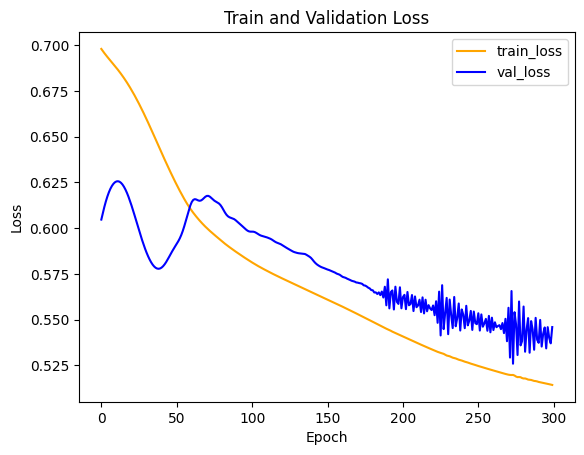

In [ ]:
print("Early termination point: ", min(val_loss, key = val_loss.get))
plot_loss(train_loss, val_loss)


Classification_report:

              precision    recall  f1-score   support

         0.0       0.99      0.67      0.80    116149
         1.0       0.03      0.71      0.06      1806

    accuracy                           0.67    117955
   macro avg       0.51      0.69      0.43    117955
weighted avg       0.98      0.67      0.79    117955


ROC AUC score:
0.7533478305975921

Confusion Matrix:
[[77466 38683]
 [  522  1284]]




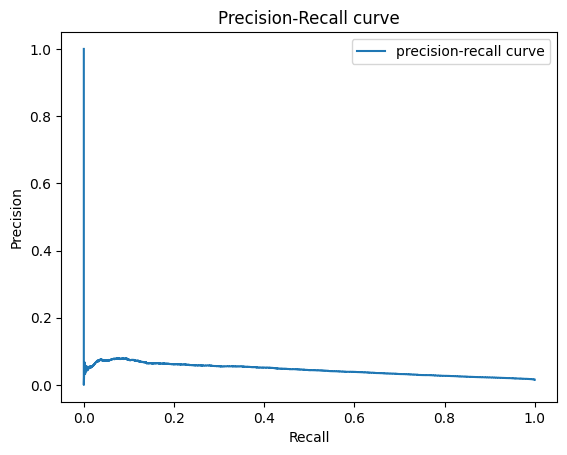

Thresholds:  [2.5705654e-08 2.7383054e-08 3.3296690e-08 ... 9.8689437e-01 9.8918867e-01
 9.9536765e-01]

Total Number of transactions (For Eval): 117955

Actual Fraud Transactions: 1806.0
TPs (Correctly Identified Frauds): 1284
FPs (Incorrectly Identified Frauds): 38683


In [ ]:
evaluate(model = model, X_test=X_test, y_test=y_test)

### Observations For Model-Experiment 2:  

Classification report for the model's performance on test set show cases following :

-  F1 score is improved a bit over Experiment 1
- Overall model performance judged by AUC-ROC score is okay with 0.75, an improvement over the Logistic Regression

- Precision is still low for Fraud Class and so is Recall

- Precision-Recall Curve shows that model has high recall at expense of precison, as recall increases, precision decreases sharply. It is near 0, when recall is near 1
    - The point where curve bends ("Elbow") is what wouldbe considered agood trade-off point for this model. But, the exchat choice of this point is based on business requirements and the cost of FP (False-Positive) transactions.


#### Analysis for Business needs:

- I think it's important for business to reduce the loss of money, by avoding fraud transactions. The True-Positive rate should be high, i.e the fraud transactions being rightly predicted as fraudulent by our mode. Thus, the percentage amount of True-positive transactions to the total fraud transactions should be high.

- Other important point is that we can consider less model effect on False-Postive rate, wrongly determining the transactions as fraudulent when they are not fraudulent. This is still okay, as monetary wise we are not losing money. Ideallyk, percentatge of transations predicted fraudulent but not (FP)/total real fraud transactions should be low.

#### Conclusion:

From Experiment 2, it is clear that our Hypothesis of NN Performing better works and they can capture better trends, now is a matter of scaling the parameters and doing better and longer training to get all the fruits of our efforst

### Model Experiment 3 : Bigger NN and Better Training

As from our experiment 2, we proved that Neural Networks are capable of learning from data and identifying important trends in the distribution. It was better than Logistic Regression's performance. But we can do even better. We can use a larger NN architecture and train it effectively.

Let's see the new model architecture.

- Increasing the number of neurons in hidden layers from 64 to 1024
- We are adding dropout layers to prevent overfitting
- We are adding batch normalization layers to stabilize the training process

Whys ?

1. Why larger number of neurons in hidden layers ?
    - We are building a larger NN on hypothesis that it will learn more complex patterns in the data. The more the neurons/parameters, the better it will capture the complexity of the data.

2. Why adding dropout layers ?
    - We are adding dropout layers to prevent overfitting. Dropout layers randomly drop out some neurons in the network. This helps to prevent the model from memorizing the training data and learning the noise in the data.

3. Why adding batch normalization layers ?
    - We are adding batch normalization layers to stabilize the training process. Batch normalization layers normalize the input data before passing it through the network. This helps to prevent the model from getting overwhelmed by the data and learning the noise in the data. Also proven to handle inner-covariate shift.


Since the model is relatively larger, and better, we should be doing our training in batches instead of updating gradients over the whole iteration of dataset. This particular addition is very helpful, as now our loss fn can much better converge and the training larger models with batches is generally proven to be better to achieve convergence.

Additionally, we will be using LR Schedulers, I experimented with `StepScheduler`and `ReduceLROnPlateu`, choosing latter one, we are going to schedule our learning rate to adapt with the val loss over the course of epochs. As to get the most optimal performance for the batch size and lr.

In [ ]:
class FraudDetector(nn.Module):
    def __init__(self, input_dim):
        super(FraudDetector, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.final = nn.Linear(32, 1)
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(64)
        self.bn6 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.dropout(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        x = self.dropout(x)
        x = self.bn3(self.fc3(x))
        x = self.relu(x)
        x = self.dropout(x)
        x = self.bn4(self.fc4(x))
        x = self.relu(x)
        x = self.dropout(x)
        x = self.bn5(self.fc5(x))
        x = self.relu(x)
        x = self.dropout(x)
        x = self.bn6(self.fc6(x))
        x = self.relu(x)
        x = self.dropout(x)
        x = self.sigmoid(self.final(x))
        return x


In [ ]:
def train_in_batches(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, epochs, batch_size, scheduler):
    train_ds = TensorDataset(X_train, y_train)
    val_ds = TensorDataset(X_val, y_val)

    # Loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True) # Shuffle is true for training
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    train_loss = {}
    val_loss = {}

    for epoch in range(epochs):
        # Set model to train mode
        model.train()
        epoch_loss = 0

        # Training loop with progress bar using tqdm to get estimates of time remaining and speed
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for batch_X, batch_y in train_loader_tqdm:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            train_loader_tqdm.set_postfix({'train_loss': loss.item()})


        # maintaing training loss for plots
        train_loss[epoch] = epoch_loss / len(train_loader)

        # Validation loss
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            val_loader_tqdm = tqdm(val_loader, desc=f"Validating", leave=False)
            for batch_X, batch_y in val_loader_tqdm:
                outputs = model(batch_X)
                val_loss_batch = loss_fn(outputs, batch_y).item()
                val_epoch_loss += val_loss_batch
                val_loader_tqdm.set_postfix({'val_loss': val_loss_batch})

        # Step the learning rate scheduler based on the val loss
        scheduler.step(val_epoch_loss)

        # maintaing validation loss for plots
        val_loss[epoch] = val_epoch_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss[epoch]}, Val Loss: {val_loss[epoch]}, LR: {scheduler.get_last_lr()[0]}")

    return train_loss, val_loss


In [ ]:
model = FraudDetector(X_train.shape[1]).to(device)
loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR by a factor of 0.1 every 10 epochs
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
epochs = 25

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
torch.cuda.empty_cache()
print("Starting Training, using device:", device)
train_loss, val_loss = train_in_batches(model = model, loss_fn=loss, optimizer=optimizer, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=epochs, batch_size = 1024, scheduler=scheduler)

Starting Training, using device: cuda


Epoch 1/25: Train Loss: 0.5634685834699131, Val Loss: 0.5272462290936503, LR: 0.003


Epoch 2/25: Train Loss: 0.521629198865017, Val Loss: 0.4757937090150241, LR: 0.003


Epoch 3/25: Train Loss: 0.5015517443108941, Val Loss: 0.49027111997892114, LR: 0.003


Epoch 4/25: Train Loss: 0.48672476151959865, Val Loss: 0.46504421763379, LR: 0.003


Epoch 5/25: Train Loss: 0.47514438066311443, Val Loss: 0.451494949388093, LR: 0.003


Epoch 6/25: Train Loss: 0.4647579980526925, Val Loss: 0.44804222804719, LR: 0.003


Epoch 7/25: Train Loss: 0.45795493133232434, Val Loss: 0.44672757361469595, LR: 0.003


Epoch 8/25: Train Loss: 0.45052990280760136, Val Loss: 0.4265644234316102, LR: 0.003


Epoch 9/25: Train Loss: 0.4453554769469613, Val Loss: 0.41906198730756494, LR: 0.003


Epoch 10/25: Train Loss: 0.44067585746897514, Val Loss: 0.4531094938002784, LR: 0.003


Epoch 11/25: Train Loss: 0.43828710708221924, Val Loss: 0.4122217680359709, LR: 0.003


Epoch 12/25: Train Loss: 0.4324117900629557, Val Loss: 0.4194936862793462, LR: 0.003


Epoch 13/25: Train Loss: 0.42801004907114537, Val Loss: 0.4200068761048646, LR: 0.003


Epoch 14/25: Train Loss: 0.42524416520980535, Val Loss: 0.39963421379697733, LR: 0.003


Epoch 15/25: Train Loss: 0.42313329443490316, Val Loss: 0.40120423533793154, LR: 0.003


Epoch 16/25: Train Loss: 0.4204069213049945, Val Loss: 0.3982848489078982, LR: 0.003


Epoch 17/25: Train Loss: 0.41712658390107304, Val Loss: 0.3976519588252594, LR: 0.003


Epoch 18/25: Train Loss: 0.4159623317216454, Val Loss: 0.39419956042848786, LR: 0.003


Epoch 19/25: Train Loss: 0.4138203439169948, Val Loss: 0.4096534876474019, LR: 0.003


Epoch 20/25: Train Loss: 0.4106901613634864, Val Loss: 0.3679179849809614, LR: 0.003


Epoch 21/25: Train Loss: 0.40977208264263537, Val Loss: 0.37080809987824537, LR: 0.003


Epoch 22/25: Train Loss: 0.40732522535369126, Val Loss: 0.38560871831301985, LR: 0.003


Epoch 23/25: Train Loss: 0.4053798724841801, Val Loss: 0.3845301216532444, LR: 0.003


Epoch 24/25: Train Loss: 0.40447925716441574, Val Loss: 0.37433363394490604, LR: 0.003


Epoch 25/25: Train Loss: 0.4023749358930939, Val Loss: 0.41453843897786635, LR: 0.003


Early termination point:  19


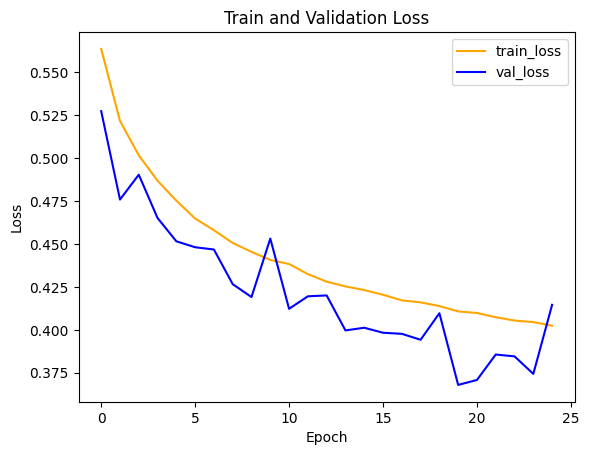

In [ ]:
print("Early termination point: ", min(val_loss, key = val_loss.get))
plot_loss(train_loss, val_loss)


Classification_report:

              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86    116149
         1.0       0.04      0.68      0.08      1806

    accuracy                           0.75    117955
   macro avg       0.52      0.72      0.47    117955
weighted avg       0.98      0.75      0.85    117955


ROC AUC score:
0.7937477242996397

Confusion Matrix:
[[87797 28352]
 [  581  1225]]




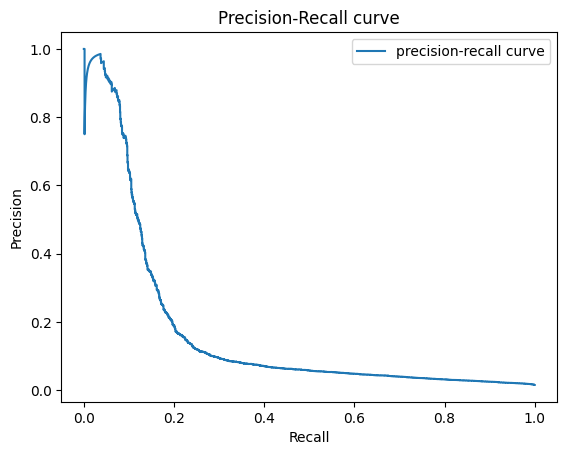

Thresholds:  [1.2376797e-10 1.5880304e-10 2.3968461e-10 ... 9.9966300e-01 9.9969077e-01
 9.9973863e-01]

Total Number of transactions (For Eval): 117955

Actual Fraud Transactions: 1806.0
TPs (Correctly Identified Frauds): 1225
FPs (Incorrectly Identified Frauds): 28352


In [ ]:
evaluate(model = model, X_test=X_test, y_test=y_test)

### Observations from Model Experiment-3:  

Classification report for the model's performance on test set show cases following :

- Even higher ROC-AUC score, surpassing previous experiments
- TPs are high, and F1-score overall has shown improvement
- With time train and val loss are decreasing which is great

#### Conclusion:

Given improved perfomed perfomance of our model show case the potential of increasing architecture size of NN and scaling with training.

From these insights, we can shift to bigger architectures, train for longer periods of time and get better performance, precison, and results.

Business needs detection rate of Fraudulent Transactions to be high and from above experiments it entails that bigger and better trained models can lead to optimal results.

### Model Experiment-4:

Inspired from the previous insights related to training larger and better models, Development of transformers for their attention mechanism and recent improvements to tackle Tabular Data. I thought of using transformers for this last experiment.

I wanted to solve the Fraud Detection problem using TabNet Transformer.

Why TabNet?

There were a lot of recent papers and research done to use TabNet transformer for tabular data, many great Kaggle Competition submissions used this, and it is showing promising results compared to old ML models.


How it works?

In a way it is similar to decision tree, it:
1. pre-selects features to use in learning thus data dimension reduction, and only using them effectively is analagous to how decision tree selects a feature at each node and then branches it by categorizing the fature, thus reducing dimensions.
2. TabNet's Encoder learns through feedback from previous results, just like tree-ensemble transfers the error value from previous tree to the next to effectively punish the wrong predicted data.

It has two components:
1. Feature Transformer: which learns complex reprenstation of features
2. Attentive Transormer: main feature selector foe features to use at each step.



Why use in Fraud Detection here ?

It's results compared to traditional ML algorithms in papers and competitions concerining tabular data is what made me interested to try here. Moreover, it has a better attention-based logic to value different features for different transactions which is helpful in case of fraud detection in credit cards as there can be lots of hidden and differnt patterns for different types of attempt at fraud in transactions.



TabNet Transformer Implementation:

For this implementation, I took help of following resources:

1. Original Tensorflow implementation by Google Research: [Link](https://github.com/google-research/google-research/blob/master/tabnet/tabnet_model.py)
2. Microsoft's Pytorch implementation : [Link](https://github.com/microsoft/qlib/blob/main/qlib/contrib/model/pytorch_tabnet.py)
3. Pytorch-Tabular Library: [Link](https://github.com/manujosephv/pytorch_tabular) -- Although,they provided a library to use, I reference their code for model understanding
4. TabNet Pytorch implementation : [Link](https://github.com/dreamquark-ai/tabnet.git)

I have added explanation of code below for better understanding:

- The model for training is taking in the input dimensions of features
- `n_d` represents dimensions for our decision prediction layer
- `n_a` represents dimensions for our attention layer
- `n_steps` as name suggests are steps we take for decision
- `gamma`, `epsilon` are their as per the formula discussed in the paper, for feature reusage coefficent and numerical stability respectively
- `n_indepent` is indepndent layer count, we will keep it 2
- `n_shared` is shared layer count, keeping same as 2

We will be having two components, feature transformer and attentive transformer, these comprise of linear and relu blocks


The `forward` function:
- Here we will first take the prior tensors setting them as `1`s for now, it shows our initial feature importance
- Then, we for each step in our total step count, apply the attention transformer, in turn get the Mask `M`
- This gives `M_loss` which helps in encouraging sparsity and in turn helps in feature selection
- We apply the masked input `(M*x)` to the feature transformer, get decisoin outputs across `d` steps.
- We then finally update `prior` for next step, reducing importance of used features, and focusing on new features
- After `n_steps` finally we apply sigmoid to get our binary classification


In [ ]:
class TabNetFraudDetector(nn.Module):
    def __init__(self, input_dim, output_dim=1, n_d=64, n_a=64, n_steps=5, gamma=1.3, n_independent=2, n_shared=2, epsilon=1e-15):
        super(TabNetFraudDetector, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_independent = n_independent
        self.n_shared = n_shared

        self.feature_transformer = nn.ModuleList()
        self.attentive_transformer = nn.ModuleList()

        for step in range(n_steps):
            self.feature_transformer.append(
                nn.Sequential(
                    nn.Linear(input_dim, n_d + n_a),
                    nn.ReLU(inplace=False),
                    nn.Linear(n_d + n_a, n_d + n_a),
                    nn.ReLU(inplace=False)
                )
            )
            self.attentive_transformer.append(
                nn.Sequential(
                    nn.Linear(input_dim, n_a),
                    nn.ReLU(inplace=False),
                    nn.Linear(n_a, input_dim),
                    nn.Sigmoid()
                )
            )

        self.final_layer = nn.Linear(n_d, output_dim)

    def forward(self, x):
        prior = torch.ones(x.shape).to(x.device)
        M_loss = 0

        for step in range(self.n_steps):
            M = self.attentive_transformer[step](prior * x)
            M_loss += torch.mean(torch.sum(torch.abs(M[:, 1:] - M[:, :-1]), dim=1))

            masked_x = M * x
            out = self.feature_transformer[step](masked_x)
            d = F.relu(out[:, :self.n_d], inplace=False)

            if step == 0:
                aggregated_d = d
            else:
                aggregated_d = aggregated_d + d

            prior = torch.mul(self.gamma - M, prior)

        final_out = self.final_layer(aggregated_d)
        return torch.sigmoid(final_out), M_loss

def create_tabnet_model(input_dim, device):
    model = TabNetFraudDetector(input_dim=input_dim).to(device)
    return model

For training, I recreated the train function, to better suit for the tabnet model as we will be also outputting M_loss along with prediction

Additionally, I am saving the model with the best val loss, loading that finally for evaluation

In [ ]:
def train_tabnet(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, clip_value=1.0, save_path = 'best_tabnet.pth'):
    best_val_loss = float('inf')
    train_losses = {}
    val_losses = {}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            y_pred, M_loss = model(batch_X)
            loss = criterion(y_pred, batch_y) + 0.001 * M_loss
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                y_pred, M_loss = model(batch_X)
                loss = criterion(y_pred, batch_y) + 0.001 * M_loss
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses[epoch] = train_loss
        val_losses[epoch] = val_loss

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), f'best_tabnet_model.pth')
            # Checkpointing the best model
            torch.save(
                {
                  'epoch' : epoch,
                  'model_state_dict' : model.state_dict(),
                  'optimizer_state_dict' : optimizer.state_dict(),
                  'val_loss' : val_loss,
                }, save_path
            )
            print(f"Best model so far saved at epoch {epoch} to {save_path}")
    return model, train_losses, val_losses

In [ ]:
model = create_tabnet_model(input_dim=X_train.shape[1], device=device)

# Same as previous experiments to righlty compare models
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Preparing data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [ ]:
trained_model, train_losses, val_losses = train_tabnet(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, device=device, clip_value=1.0)


Epoch 1/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.88it/s] 


Epoch 1/50, Train Loss: 0.4900, Val Loss: 0.4882
Best model so far saved at epoch 0 to best_tabnet.pth


Epoch 2/50: 100%|██████████| 8465/8465 [01:31<00:00, 92.77it/s]


Epoch 2/50, Train Loss: 0.4102, Val Loss: 0.5090


Epoch 3/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.57it/s]


Epoch 3/50, Train Loss: 0.3694, Val Loss: 0.4354
Best model so far saved at epoch 2 to best_tabnet.pth


Epoch 4/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.56it/s]


Epoch 4/50, Train Loss: 0.3436, Val Loss: 0.4008
Best model so far saved at epoch 3 to best_tabnet.pth


Epoch 5/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.63it/s] 


Epoch 5/50, Train Loss: 0.3248, Val Loss: 0.4003
Best model so far saved at epoch 4 to best_tabnet.pth


Epoch 6/50: 100%|██████████| 8465/8465 [01:27<00:00, 97.14it/s] 


Epoch 6/50, Train Loss: 0.3097, Val Loss: 0.4256


Epoch 7/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.39it/s] 


Epoch 7/50, Train Loss: 0.2983, Val Loss: 0.4183


Epoch 8/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.65it/s] 


Epoch 8/50, Train Loss: 0.2885, Val Loss: 0.3443
Best model so far saved at epoch 7 to best_tabnet.pth


Epoch 9/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.69it/s] 


Epoch 9/50, Train Loss: 0.2793, Val Loss: 0.3282
Best model so far saved at epoch 8 to best_tabnet.pth


Epoch 10/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.83it/s] 


Epoch 10/50, Train Loss: 0.2715, Val Loss: 0.3972


Epoch 11/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.97it/s]


Epoch 11/50, Train Loss: 0.2652, Val Loss: 0.3390


Epoch 12/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.74it/s]


Epoch 12/50, Train Loss: 0.2588, Val Loss: 0.3435


Epoch 13/50: 100%|██████████| 8465/8465 [01:27<00:00, 97.07it/s] 


Epoch 13/50, Train Loss: 0.2534, Val Loss: 0.3577


Epoch 14/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.37it/s]


Epoch 14/50, Train Loss: 0.2494, Val Loss: 0.3310


Epoch 15/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.92it/s] 


Epoch 15/50, Train Loss: 0.2444, Val Loss: 0.3320


Epoch 16/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.16it/s] 


Epoch 16/50, Train Loss: 0.2401, Val Loss: 0.2998
Best model so far saved at epoch 15 to best_tabnet.pth


Epoch 17/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.58it/s] 


Epoch 17/50, Train Loss: 0.2366, Val Loss: 0.3561


Epoch 18/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.94it/s]


Epoch 18/50, Train Loss: 0.2334, Val Loss: 0.3335


Epoch 19/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.43it/s]


Epoch 19/50, Train Loss: 0.2303, Val Loss: 0.3123


Epoch 20/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.74it/s] 


Epoch 20/50, Train Loss: 0.2264, Val Loss: 0.3541


Epoch 21/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.52it/s] 


Epoch 21/50, Train Loss: 0.2243, Val Loss: 0.3317


Epoch 22/50: 100%|██████████| 8465/8465 [01:28<00:00, 96.03it/s] 


Epoch 22/50, Train Loss: 0.2213, Val Loss: 0.3564


Epoch 23/50: 100%|██████████| 8465/8465 [01:28<00:00, 96.03it/s] 


Epoch 23/50, Train Loss: 0.2186, Val Loss: 0.3284


Epoch 24/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.89it/s] 


Epoch 24/50, Train Loss: 0.2160, Val Loss: 0.3290


Epoch 25/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.32it/s]


Epoch 25/50, Train Loss: 0.2134, Val Loss: 0.3340


Epoch 26/50: 100%|██████████| 8465/8465 [01:27<00:00, 97.27it/s] 


Epoch 26/50, Train Loss: 0.2114, Val Loss: 0.2910
Best model so far saved at epoch 25 to best_tabnet.pth


Epoch 27/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.71it/s]


Epoch 27/50, Train Loss: 0.2090, Val Loss: 0.3419


Epoch 28/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.27it/s] 


Epoch 28/50, Train Loss: 0.2073, Val Loss: 0.3114


Epoch 29/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.84it/s] 


Epoch 29/50, Train Loss: 0.2049, Val Loss: 0.3917


Epoch 30/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.90it/s]


Epoch 30/50, Train Loss: 0.2033, Val Loss: 0.3102


Epoch 31/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.48it/s]


Epoch 31/50, Train Loss: 0.2014, Val Loss: 0.3213


Epoch 32/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.63it/s]


Epoch 32/50, Train Loss: 0.1999, Val Loss: 0.2891
Best model so far saved at epoch 31 to best_tabnet.pth


Epoch 33/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.92it/s] 


Epoch 33/50, Train Loss: 0.1976, Val Loss: 0.2397
Best model so far saved at epoch 32 to best_tabnet.pth


Epoch 34/50: 100%|██████████| 8465/8465 [01:28<00:00, 96.16it/s] 


Epoch 34/50, Train Loss: 0.1967, Val Loss: 0.2898


Epoch 35/50: 100%|██████████| 8465/8465 [01:29<00:00, 94.28it/s] 


Epoch 35/50, Train Loss: 0.1949, Val Loss: 0.3841


Epoch 36/50: 100%|██████████| 8465/8465 [01:29<00:00, 94.47it/s]


Epoch 36/50, Train Loss: 0.1930, Val Loss: 0.3243


Epoch 37/50: 100%|██████████| 8465/8465 [01:29<00:00, 94.80it/s] 


Epoch 37/50, Train Loss: 0.1917, Val Loss: 0.3285


Epoch 38/50: 100%|██████████| 8465/8465 [01:29<00:00, 94.51it/s] 


Epoch 38/50, Train Loss: 0.1909, Val Loss: 0.3286


Epoch 39/50: 100%|██████████| 8465/8465 [01:29<00:00, 95.05it/s] 


Epoch 39/50, Train Loss: 0.1889, Val Loss: 0.3011


Epoch 40/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.45it/s]


Epoch 40/50, Train Loss: 0.1878, Val Loss: 0.3256


Epoch 41/50: 100%|██████████| 8465/8465 [01:29<00:00, 95.08it/s]


Epoch 41/50, Train Loss: 0.1864, Val Loss: 0.3083


Epoch 42/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.41it/s]


Epoch 42/50, Train Loss: 0.1852, Val Loss: 0.3225


Epoch 43/50: 100%|██████████| 8465/8465 [01:28<00:00, 96.18it/s] 


Epoch 43/50, Train Loss: 0.1839, Val Loss: 0.2785


Epoch 44/50: 100%|██████████| 8465/8465 [01:28<00:00, 96.00it/s] 


Epoch 44/50, Train Loss: 0.1830, Val Loss: 0.3107


Epoch 45/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.84it/s]


Epoch 45/50, Train Loss: 0.1405, Val Loss: 0.2770


Epoch 46/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.23it/s] 


Epoch 46/50, Train Loss: 0.1336, Val Loss: 0.2760


Epoch 47/50: 100%|██████████| 8465/8465 [01:28<00:00, 96.06it/s]


Epoch 47/50, Train Loss: 0.1311, Val Loss: 0.2711


Epoch 48/50: 100%|██████████| 8465/8465 [01:28<00:00, 95.49it/s] 


Epoch 48/50, Train Loss: 0.1293, Val Loss: 0.2705


Epoch 49/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.87it/s]


Epoch 49/50, Train Loss: 0.1278, Val Loss: 0.2805


Epoch 50/50: 100%|██████████| 8465/8465 [01:27<00:00, 96.88it/s] 


Epoch 50/50, Train Loss: 0.1265, Val Loss: 0.2791


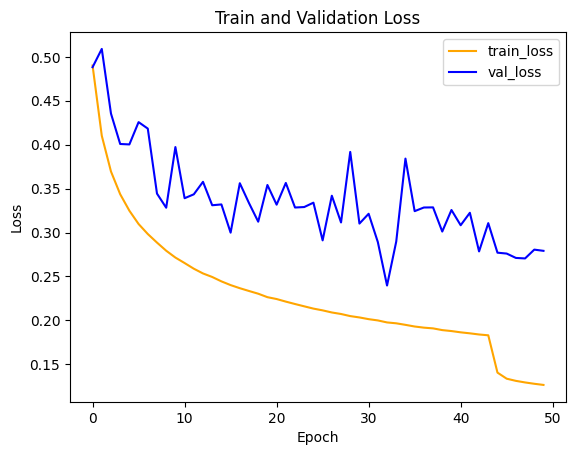

In [ ]:
plot_loss(train_losses, val_losses)

In [ ]:
def evaluate_tabnet(model, X_test, y_test):
    # set to eval mode
    model.eval()
    with torch.no_grad():
        preds, _ = model(X_test)
        pred_class = preds.round()

    print("\nClassification_report:\n")
    print(classification_report(y_test.cpu(), pred_class.cpu()))
    print("\nROC AUC score:")
    print(roc_auc_score(y_test.cpu(), preds.cpu()))
    cm = confusion_matrix(y_test.cpu(), pred_class.cpu())
    print("\nConfusion Matrix:")
    print(cm)
    print('\n')
    p,r, thresholds = precision_recall_curve(y_test.cpu(), preds.cpu())
    plt.plot(r, p, label='precision-recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend()
    plt.show()
    print("Thresholds: ", thresholds)

    # Analysis of Fraud transactions

    y_real = y_test.cpu().numpy()
    y_pred = pred_class.cpu().numpy()
    total_transactions = len(y_real)
    total_actual_fraud = y_real.sum()
    total_actual_non_fraud = total_transactions - total_actual_fraud
    total_predicted_fraud = pred_class.sum()

    TP = ((y_pred == 1) & (y_real == 1)).sum()
    FP = ((y_pred == 1) & (y_real == 0)).sum()

    print(f"\nTotal Number of transactions (For Eval): {total_transactions}")
    print(f"\nActual Fraud Transactions: {total_actual_fraud}")
    print(f"TPs (Correctly Identified Frauds): {TP}")
    print(f"FPs (Incorrectly Identified Frauds): {FP}")



Classification_report:

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95    116149
         1.0       0.07      0.37      0.11      1806

    accuracy                           0.91    117955
   macro avg       0.53      0.65      0.53    117955
weighted avg       0.98      0.91      0.94    117955


ROC AUC score:
0.7624869607714617

Confusion Matrix:
[[106647   9502]
 [  1132    674]]




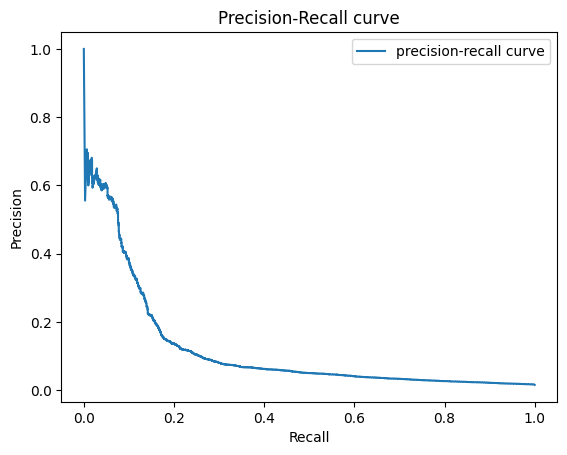

Thresholds:  [0.0000000e+00 3.5925733e-39 4.3550142e-39 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]

Total Number of transactions (For Eval): 117955

Actual Fraud Transactions: 1806.0
TPs (Correctly Identified Frauds): 674
FPs (Incorrectly Identified Frauds): 9502


In [ ]:
evaluate_tabnet(trained_model, X_test, y_test)

In [ ]:
# Using best model with best val loss
save_path = 'best_tabnet.pth'

def load_best_model(model, save_path, device):
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    return model, checkpoint['epoch'], checkpoint['val_loss']

print(f"Using device : {device}")
if os.path.exists(save_path):
    best_model = create_tabnet_model(input_dim=X_train.shape[1], device=device)
    best_model, epoch_num, best_val_loss = load_best_model(best_model, save_path, device)
    print(f"Loaded best model from epoch {epoch_num} with val loss {best_val_loss:.4f}")

Using device : cuda
Loaded best model from epoch 32 with val loss 0.2397


<ipython-input-59-8b590cd4bbc1>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)



Classification_report:

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96    116149
         1.0       0.07      0.34      0.11      1806

    accuracy                           0.92    117955
   macro avg       0.53      0.63      0.54    117955
weighted avg       0.97      0.92      0.94    117955


ROC AUC score:
0.7685650192114424

Confusion Matrix:
[[107815   8334]
 [  1194    612]]




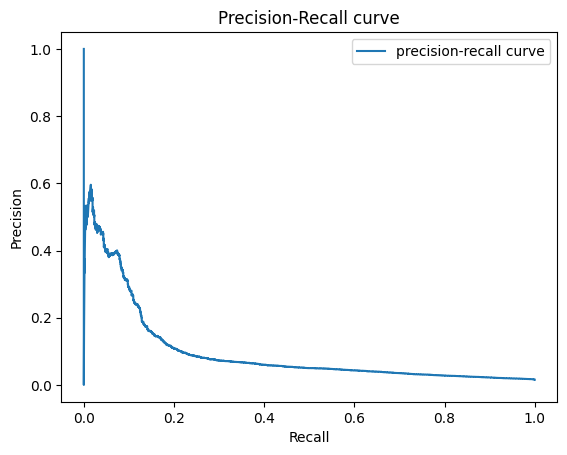

Thresholds:  [0.0000000e+00 6.1489159e-39 7.1473578e-39 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]

Total Number of transactions (For Eval): 117955

Actual Fraud Transactions: 1806.0
TPs (Correctly Identified Frauds): 612
FPs (Incorrectly Identified Frauds): 8334


In [ ]:
# evaluation of best model

evaluate_tabnet(best_model, X_test, y_test)

### Observations from Model Experiment-4:

Classification report for the model's performance on test set show cases following :

- We got much better preicion (0.07) compared to previous (0.04) for test set
- We got better F1-score (0.11) compared to previous of (0.08)
- ROC-AUC score is relatively lower, but overall the training and validation loss while model training across 50 epochs was decreasing, which is good sign.
- The PR curve although showing bit fluctations, atleast is relatively better than our initial experiments.

There's one issue, I believe since the train loss is so low, it maybe that our model might be over-fitting a bit.

To investigate this, let's just simply look at evaluation on the training set


Classification_report:

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91    541720
         1.0       0.94      0.88      0.91    541720

    accuracy                           0.91   1083440
   macro avg       0.91      0.91      0.91   1083440
weighted avg       0.91      0.91      0.91   1083440


ROC AUC score:
0.9763289328372654

Confusion Matrix:
[[508697  33023]
 [ 64290 477430]]




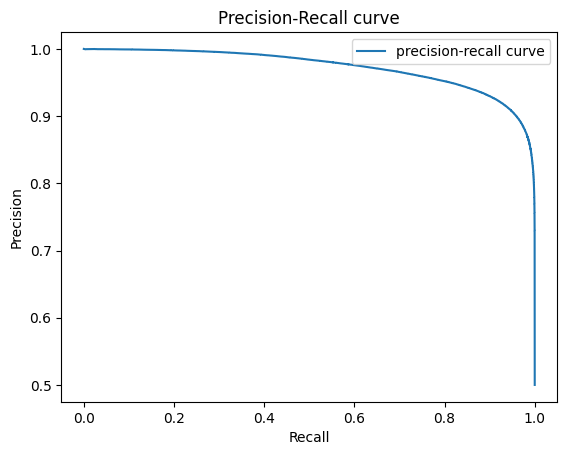

Thresholds:  [0.0000000e+00 3.2585710e-39 3.3307603e-39 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]

Total Number of transactions (For Eval): 1083440

Actual Fraud Transactions: 541720.0
TPs (Correctly Identified Frauds): 477430
FPs (Incorrectly Identified Frauds): 33023


In [ ]:
# Evaluating on Train set to see overfitting nature or not
evaluate_tabnet(best_model, X_train, y_train)

Clearly, Upon doing evalution on the training set for the TabNet based model, we can see that the ROC-AUC score is very high (0.97), precision is (0.94) for Fraud Class, so is F1 score (0.91). This shows that our model has learnt to cram-up the training data and thus seems to be overfitting.

Business Needs: As we want higher TPs (cases where it was fraud and we preidicted right) and less FNs (cases wher it was fraud but model predicted as non-fraud) as it's important to flag fraud transactions, and miss out on any fraudulent ones.

#### Conclusion:

Given much better training performance and increased precision and F1-score using TabNet Transformer to select features and pay attention to them while getting feedback and refining each step. We can conclude that this model can be a viable option to be proceed with to train on larger data and for longer times. However, due to it's overfitting which although can be solved with training on more data, for now we can experiment with using other ways to tackle overfitting, such as incorporating Dropout, Batch Normalization, and L2 Regularization to training.


#### Model Experiment-5:

Adding Dropout, BN to TabNet Model, Using Focal Loss as our Loss Fn.

As mentioned in the above conclusion, we are now using following things to reduce overfitting:

- Dropout -- as we did for experiment 3, adding dropouts help in reducing overfitting
- Adding batch normalization after each linear layer

On the Training side, I am making following improvements and explaining the reasoning behing them:

- Changing from Binary Cross-Entropy Loss `nn.BCELoss()` to **Focal Loss**
  - `FocalLoss` - It is basically a modified version of standard cross entropy loss, specifically used to deal with problem of class imbalance, which is the case with our Fraud Detection Dataset.
  - Since Fraudulent Transactions are very less, making Fraud Class as minority, we are going to penalize harder on misclassification of true fraud class points.
  - Focal Loss is defined as `FL = -alpha * (1 -p) ^ gamma * log(p)
    - Here, alpha is used for balancing, gamma for focusing.
    - alpha between (0,1) - here setting it to say 0.25 means 25% samples are positive, 75% are negative
    - gamma helps in down-weighting easy examples (majority class). So, range is [0,5] -- setting to 2 is default

- References: 
  1. Focal Loss: [Link](https://discuss.pytorch.org/t/implementing-focal-loss-for-a-binary-classification-problem/128664), [Link2](https://github.com/clcarwin/focal_loss_pytorch)

  

In [ ]:
class TabNetFraudDetectorV2(nn.Module):
    def __init__(self, input_dim, output_dim=1, n_d=64, n_a=64, n_steps=5, gamma=1.3, n_independent=2, n_shared=2, epsilon=1e-15, dropout_rate=0.1):
        super(TabNetFraudDetectorV2, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_independent = n_independent
        self.n_shared = n_shared
        self.dropout_rate = dropout_rate

        self.feature_transformer = nn.ModuleList()
        self.attentive_transformer = nn.ModuleList()

        for step in range(n_steps):
            self.feature_transformer.append(
                nn.Sequential(
                    nn.Linear(input_dim, n_d + n_a),
                    nn.BatchNorm1d(n_d + n_a),
                    nn.ReLU(inplace=False),
                    nn.Dropout(dropout_rate),
                    nn.Linear(n_d + n_a, n_d + n_a),
                    nn.BatchNorm1d(n_d + n_a),
                    nn.ReLU(inplace=False),
                    nn.Dropout(dropout_rate)
                )
            )
            self.attentive_transformer.append(
                nn.Sequential(
                    nn.Linear(input_dim, n_a),
                    nn.BatchNorm1d(n_a),
                    nn.ReLU(inplace=False),
                    nn.Dropout(dropout_rate),
                    nn.Linear(n_a, input_dim),
                    nn.Sigmoid()
                )
            )

        self.final_layer = nn.Sequential(
            nn.Linear(n_d, n_d // 2),
            nn.BatchNorm1d(n_d // 2),
            nn.ReLU(inplace=False),
            nn.Dropout(dropout_rate),
            nn.Linear(n_d // 2, output_dim)
        )

    def forward(self, x):
        prior = torch.ones(x.shape).to(x.device)
        M_loss = 0

        for step in range(self.n_steps):
            M = self.attentive_transformer[step](prior * x)
            M_loss += torch.mean(torch.sum(torch.abs(M[:, 1:] - M[:, :-1]), dim=1))

            masked_x = M * x
            out = self.feature_transformer[step](masked_x)
            d = F.relu(out[:, :self.n_d], inplace=False)

            if step == 0:
                aggregated_d = d
            else:
                aggregated_d = aggregated_d + d

            prior = torch.mul(self.gamma - M, prior)

        final_out = self.final_layer(aggregated_d)
        return torch.sigmoid(final_out), M_loss

In [ ]:
def create_tabnet_modelV2(input_dim, device):
    model = TabNetFraudDetectorV2(input_dim=input_dim).to(device)
    return model

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)


In [ ]:
model = create_tabnet_modelV2(input_dim=X_train.shape[1], device=device)

# Same as previous experiments to righlty compare models
criterion = FocalLoss(alpha=0.25, gamma = 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Preparing data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
print(f"Using device : {device}")

Using device : cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
trained_model, train_losses, val_losses = train_tabnet(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=30, device=device, clip_value=1.0, save_path=checkpoint_path,
)

Epoch 1/30: 100%|██████████| 8465/8465 [02:09<00:00, 65.36it/s]


Epoch 1/30, Train Loss: 0.0334, Val Loss: 0.0336
Best model so far saved at epoch 0 to best_tabnet_model.pth


Epoch 2/30: 100%|██████████| 8465/8465 [02:08<00:00, 65.91it/s]


Epoch 2/30, Train Loss: 0.0302, Val Loss: 0.0307
Best model so far saved at epoch 1 to best_tabnet_model.pth


Epoch 3/30: 100%|██████████| 8465/8465 [02:08<00:00, 65.99it/s]


Epoch 3/30, Train Loss: 0.0288, Val Loss: 0.0289
Best model so far saved at epoch 2 to best_tabnet_model.pth


Epoch 4/30: 100%|██████████| 8465/8465 [02:07<00:00, 66.63it/s]


Epoch 4/30, Train Loss: 0.0278, Val Loss: 0.0298


Epoch 5/30: 100%|██████████| 8465/8465 [02:06<00:00, 66.76it/s]


Epoch 5/30, Train Loss: 0.0271, Val Loss: 0.0276
Best model so far saved at epoch 4 to best_tabnet_model.pth


Epoch 6/30: 100%|██████████| 8465/8465 [02:07<00:00, 66.23it/s]


Epoch 6/30, Train Loss: 0.0266, Val Loss: 0.0284


Epoch 7/30: 100%|██████████| 8465/8465 [02:09<00:00, 65.37it/s]


Epoch 7/30, Train Loss: 0.0261, Val Loss: 0.0292


Epoch 8/30: 100%|██████████| 8465/8465 [02:09<00:00, 65.48it/s]


Epoch 8/30, Train Loss: 0.0258, Val Loss: 0.0290


Epoch 9/30: 100%|██████████| 8465/8465 [02:10<00:00, 64.95it/s]


Epoch 9/30, Train Loss: 0.0255, Val Loss: 0.0275
Best model so far saved at epoch 8 to best_tabnet_model.pth


Epoch 10/30: 100%|██████████| 8465/8465 [02:09<00:00, 65.56it/s]


Epoch 10/30, Train Loss: 0.0252, Val Loss: 0.0268
Best model so far saved at epoch 9 to best_tabnet_model.pth


Epoch 11/30: 100%|██████████| 8465/8465 [02:08<00:00, 65.68it/s]


Epoch 11/30, Train Loss: 0.0250, Val Loss: 0.0283


Epoch 12/30: 100%|██████████| 8465/8465 [02:08<00:00, 65.88it/s]


Epoch 12/30, Train Loss: 0.0248, Val Loss: 0.0266
Best model so far saved at epoch 11 to best_tabnet_model.pth


Epoch 13/30: 100%|██████████| 8465/8465 [02:07<00:00, 66.58it/s]


Epoch 13/30, Train Loss: 0.0246, Val Loss: 0.0277


Epoch 14/30: 100%|██████████| 8465/8465 [02:07<00:00, 66.35it/s]


Epoch 14/30, Train Loss: 0.0244, Val Loss: 0.0267


Epoch 15/30: 100%|██████████| 8465/8465 [02:07<00:00, 66.43it/s]


Epoch 15/30, Train Loss: 0.0243, Val Loss: 0.0261
Best model so far saved at epoch 14 to best_tabnet_model.pth


Epoch 16/30: 100%|██████████| 8465/8465 [02:07<00:00, 66.59it/s]


Epoch 16/30, Train Loss: 0.0241, Val Loss: 0.0259
Best model so far saved at epoch 15 to best_tabnet_model.pth


Epoch 17/30: 100%|██████████| 8465/8465 [02:07<00:00, 66.20it/s]


Epoch 17/30, Train Loss: 0.0240, Val Loss: 0.0275


Epoch 18/30: 100%|██████████| 8465/8465 [02:08<00:00, 65.93it/s]


Epoch 18/30, Train Loss: 0.0238, Val Loss: 0.0245
Best model so far saved at epoch 17 to best_tabnet_model.pth


Epoch 19/30: 100%|██████████| 8465/8465 [02:06<00:00, 66.87it/s]


Epoch 19/30, Train Loss: 0.0238, Val Loss: 0.0256


Epoch 20/30: 100%|██████████| 8465/8465 [02:06<00:00, 66.71it/s]


Epoch 20/30, Train Loss: 0.0236, Val Loss: 0.0258


Epoch 21/30: 100%|██████████| 8465/8465 [02:09<00:00, 65.13it/s]


Epoch 21/30, Train Loss: 0.0236, Val Loss: 0.0256


Epoch 22/30: 100%|██████████| 8465/8465 [02:08<00:00, 65.64it/s]


Epoch 22/30, Train Loss: 0.0235, Val Loss: 0.0267


Epoch 23/30: 100%|██████████| 8465/8465 [02:08<00:00, 66.11it/s]


Epoch 23/30, Train Loss: 0.0234, Val Loss: 0.0264


Epoch 24/30: 100%|██████████| 8465/8465 [02:08<00:00, 66.10it/s]


Epoch 24/30, Train Loss: 0.0233, Val Loss: 0.0264


Epoch 25/30: 100%|██████████| 8465/8465 [02:07<00:00, 66.29it/s]


Epoch 25/30, Train Loss: 0.0232, Val Loss: 0.0259


Epoch 26/30: 100%|██████████| 8465/8465 [02:07<00:00, 66.26it/s]


Epoch 26/30, Train Loss: 0.0231, Val Loss: 0.0260


Epoch 27/30: 100%|██████████| 8465/8465 [02:06<00:00, 66.86it/s]


Epoch 27/30, Train Loss: 0.0231, Val Loss: 0.0256


Epoch 28/30: 100%|██████████| 8465/8465 [02:06<00:00, 67.16it/s]


Epoch 28/30, Train Loss: 0.0230, Val Loss: 0.0257


Epoch 29/30: 100%|██████████| 8465/8465 [02:05<00:00, 67.22it/s]


Epoch 29/30, Train Loss: 0.0230, Val Loss: 0.0267


Epoch 30/30: 100%|██████████| 8465/8465 [02:06<00:00, 66.76it/s]


Epoch 30/30, Train Loss: 0.0221, Val Loss: 0.0250


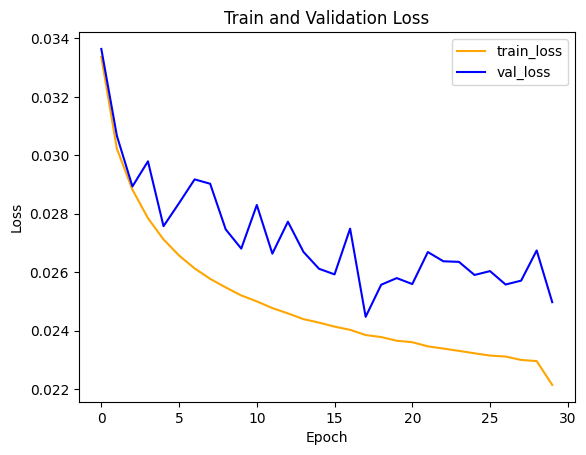

In [ ]:
plot_loss(train_losses, val_losses)


Classification_report:

              precision    recall  f1-score   support

         0.0       0.99      0.78      0.88    116149
         1.0       0.04      0.64      0.08      1806

    accuracy                           0.78    117955
   macro avg       0.52      0.71      0.48    117955
weighted avg       0.98      0.78      0.86    117955


ROC AUC score:
0.7926918360401756

Confusion Matrix:
[[91063 25086]
 [  642  1164]]




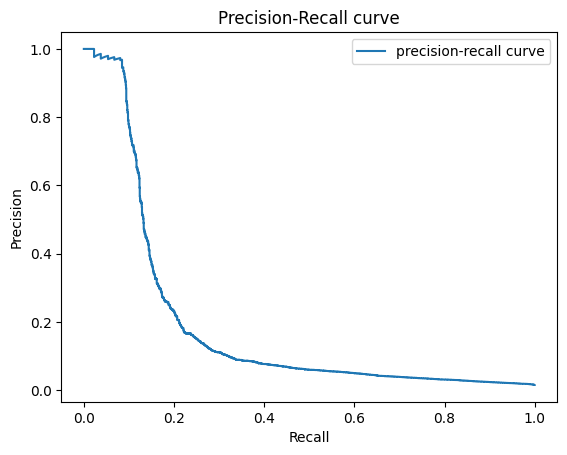

Thresholds:  [1.2494149e-11 7.5383980e-08 8.2020421e-08 ... 9.7243780e-01 9.7731596e-01
 9.9001992e-01]

Total Number of transactions (For Eval): 117955

Actual Fraud Transactions: 1806.0
TPs (Correctly Identified Frauds): 1164
FPs (Incorrectly Identified Frauds): 25086


In [94]:
# Test set eval
evaluate_tabnet(trained_model, X_test, y_test)


### Observations from Model Experiment-5:

We trained on Focal Loss for just 30 epochs, given we have not optimized the right `alpha` and `gamma` for the loss function, still following improvements are noticed. Let's dive deep into the report:

Classification report for the model's performance on **test** set show cases following :

- ROC-AUC score is relatively higher (0.7926) compared to previous (0.7685). This is a good sign and shows model is better compared to v1 tabnet in terms of distinguishing classes.

- Overall train and val loss are decreasing as we train more from the plots, which shows good model learning and not overfitting

- It can also be noticed from the the PR curve that now as recall increases although precision is decreasing but compared to earlier where we had a steep peak down, here we are relatively having gradual decrease.

- This shows, recall is relatively higher for Fraud Class as well compared to prev experiment 4

- Finally, we can see from the ***evaluation*** analysis, that out of **1806** Fraud Transactions model found correctly **1164** of the TPs, compared to **612** in Experiment-4 which is nearly twice as much. This show cases that model didn't overfit much and has actually learned to understand the nuances to detect fraud in test set better.


Classification_report:

              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87    541720
         1.0       0.82      0.97      0.89    541720

    accuracy                           0.88   1083440
   macro avg       0.89      0.88      0.88   1083440
weighted avg       0.89      0.88      0.88   1083440


ROC AUC score:
0.9509066871590877

Confusion Matrix:
[[428499 113221]
 [ 18917 522803]]




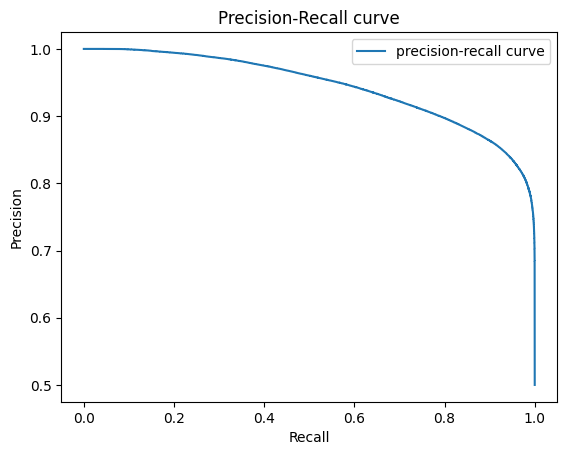

Thresholds:  [2.9757603e-12 1.0412964e-11 1.6145389e-08 ... 9.9185330e-01 9.9187487e-01
 9.9203473e-01]

Total Number of transactions (For Eval): 1083440

Actual Fraud Transactions: 541720.0
TPs (Correctly Identified Frauds): 522803
FPs (Incorrectly Identified Frauds): 113221


In [96]:
# Training set evaluation
evaluate_tabnet(trained_model, X_train, y_train)


Upon doing evalution on the training set for the TabNetV2 model, if we compare with previous TabNet model training sa in experiment 4. We can see that model learnt to capture trends instead of cramming and overfitting as the evaluation of test set is also better.

This show cases that we have (to some extent) solved overfitting issue with help of Dropouts, BN and Focal Loss.

Meeting Business Needs: As stated previously, we require high amount of TPs and less FNs, given the better performance of the experiment-5, we can say that if model is trained on properly for the dataset, it showcases potential to detect much of the fraud transactions allowing business to employ this model architecture for their use case.


#### Conclusion:

Given much better training performance and increased precision and F1-score using TabNet-TransformerV2 with dropout and BN to select features and pay attention to them while getting feedback and refining each step. We can conclude that this model can be a viable option to be proceed with to train on larger data and for longer times. Current performance also indicates good results.

##### If I had more time following things I would do next:

- Doing hyper-parameter sweep via grid search across following:
  - Learning rate
  - batch_size
  - dropout rate
  - `alpha` and `gamma` for Focal Loss to find the most optimal values based on the class distribution in dataset.
  
- Training for more epochs with larger training set as currently there is somewhat of same results for Exp-3 and Exp-5. The point of differentiation will be when we have more training time and more train set.

- Discussion with business stakeholder and analysts about trends in fraudulent transaction cases that has been observed in the recent quarters to create better and new derived variables and features in the feature engineering process to allow for better performance

- Trying different model architecures such as Graph Neural Networks (GNNs) such as varients like Graph Attention Networks - These showcase a lot potential as in recent papers related to fraud detection. 

  - This requires more feature engineering, creating relations and edge lists which requires a lot of data preprocessing tasks, but overall can be fruitful attempt as GNNs are proven to work great in these cases.


- Discussion with business stakeholders about cost and benefits for TP, FP, FN, TN to infrom selecing the optimal threshold for best performance. For instance, a FN (False Negative) detection is more costly say 100 times more than a FP (False positve) detction. This insight could help in tweaking training process including loss fn to punish model more when it does FN deteciton, but punish less for FP detection.



